In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neurd
from mesh_tools import trimesh_utils as tu
from datasci_tools import ipyvolume_utils as ipvu
from neurd import neuron_visualizations as nviz
from pathlib import Path
import os
import inspect
print(inspect.getfile(tu))


/usr/local/lib/python3.8/dist-packages/python_jsonschema_objects/__init__.py:113: UserWarning: Schema id not specified. Defaulting to 'self'
  warnings.warn("Schema id not specified. Defaulting to 'self'")


/usr/local/lib/python3.8/dist-packages/mesh_tools/trimesh_utils.py


Use MeshParty to Upload ChenLab Data 

In [108]:
#  ChenLab script to load mesh...

from meshparty import trimesh_io  # for grabbing a mesh
from meshparty import trimesh_vtk  # for visualizing meshes and skeletons
    
# provide the DENDRITIC segmentation ID for the cell of interest
dend_id = 74875092987018534 # 75507999300732200 #75507999300732200 # 75226661762888530 #75226730549251974 #75508068086991145 # 74945255505716070 # 74945461596862189 

# Get the DENDRITIC segmentation mesh from neuroglancer
mm = trimesh_io.MeshMeta(
        cv_path="precomputed://gs://zetta_jchen_mouse_cortex_001_segmentation/cell/lowres/240820_emb24_lowres_x1/seg", 
        map_gs_to_https=True)

mesh = mm.mesh(seg_id=dend_id) 

# visualize the mesh
mesh_actor = trimesh_vtk.mesh_actor(mesh,  color=(1,0,0),  opacity=0.25)
#trimesh_vtk.render_actors([mesh_actor]) #NOTE: need to close the window when done to unpause python

# store the mesh
# Define the local file path where you want to save the mesh (with .off extension)
local_file_path = "32414.off"
# Export the mesh to a .off file
mesh.export(local_file_path)
# Confirm the file has been saved
print(f"Mesh has been saved to {os.path.abspath(local_file_path)}")


#import skeletor as sk
# pre-process the mesh (may not be necessary)
#mesh_fix = sk.pre.fix_mesh(mesh) #
#mesh_fix_actor = trimesh_vtk.mesh_actor(mesh_fix,  color=(1,0,0),  opacity=0.25)
#trimesh_vtk.render_actors([mesh_actor, mesh_fix_actor]) 



Mesh has been saved to /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/32414.off


# Load the appropriate volume data inferface object

In [3]:
from neurd.vdi_microns import volume_data_interface as vdi
vdi.set_parameters_for_directory_modules()

# Data Prep: Loading mesh

In [4]:
# run this segment if we want BCM data

segment_id = 864691134917511946 # BCM
synapse_filepath = str(Path(f'./{segment_id}_synapses.csv').absolute())
synapse_filepath

from datasci_tools import pandas_utils as pu
df = pu.csv_to_df(synapse_filepath)
df

vdi.set_synapse_filepath(
    synapse_filepath
)

mesh = vdi.fetch_segment_id_mesh(
    segment_id,
    plot = True
)
mesh

/usr/local/lib/python3.8/dist-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

<trimesh.Trimesh(vertices.shape=(420741, 3), faces.shape=(865980, 3), name=`864691134917511946.off`)>

In [110]:
# ChenLab MESH
# run this cell only if we want to use chenlab mesh
segment_id = 32414
mesh = vdi.fetch_segment_id_mesh(
    segment_id,
    plot = True
)
mesh

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

<trimesh.Trimesh(vertices.shape=(178983, 3), faces.shape=(358086, 3), name=`32414.off`)>

In [5]:
from datasci_tools import pipeline

products = pipeline.PipelineProducts()
products

# Step 1: Decimation

In [6]:
"""
NOTE: an already decimated mesh is used for the example
in order to speed up time, that's why the mesh_dec
object will be overwritten with original mesh object
"""

"\nNOTE: an already decimated mesh is used for the example\nin order to speed up time, that's why the mesh_dec\nobject will be overwritten with original mesh object\n"

In [7]:
decimation_parameters = dict(
    decimation_ratio =0.25,
)

In [8]:
import time

# tu

st = time.time()
mesh_decimated = tu.decimate(
    mesh,
    **decimation_parameters
)

print(f"Total time = {time.time() - st}")

xvfb-run -n 2989 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_61034.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_61034_decimated.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/decimation_meshlab_25331286.mls
Total time = 35.131255865097046


In [9]:
# saving any parameters used or output products for later use
products.set_stage_attrs(
    stage = "decimation",
    attr_dict = dict(
        decimation_parameters = decimation_parameters,
        segment_id = segment_id,
    ),
    
)

print(products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691134917511946,
  },
}



# Step 2: Soma Identification

In [10]:
from neurd import soma_extraction_utils as sm
soma_extraction_parameters = dict()

In [11]:
# could inspect the parameters of a certain category
from neurd import parameter_utils as paru
paru.category_param_from_module(
        module = sm,
        category = "glia",
)

{'glia_volume_threshold_in_um_global': 2500,
 'glia_n_faces_threshold_global': 400000,
 'glia_n_faces_min_global': 100000}

In [12]:
# overwritting decimated mesh because original was already decimated
mesh_decimated = mesh

In [13]:
from neurd import neuron_visualizations as nviz

verbose = True

soma_products = sm.soma_indentification(
    mesh_decimated,
    verbose=verbose,
    **soma_extraction_parameters
)

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 5000.0 
large_mesh_threshold_inner = 3250.0 
soma_size_threshold = 562.5 
soma_size_threshold_max = 75000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
max_mesh_sized_filtered_away = 22500.0
xvfb-run -n 9572 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_4986.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_4986_remove_interior.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/remove_interior_70701.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_4986.off
removed temporary output file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_4986_remove_interior.off
/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_E

  0%|          | 0/13 [00:00<?, ?it/s]

      ------ Found 1 viable somas: [0.779125]
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 4324 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_763429.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_763429_poisson.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/poisson_926688.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_763429.off
removed temporary output file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_763429_poisson.off
mesh.is_watertight = True
/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/poisson_926688.mls is being deleted....
Inside sphere validater: ratio_val = 3.404317521233

  0%|          | 0/1 [00:00<?, ?it/s]

      ------ Found 1 viable somas: [0.5418655]
mesh.is_watertight = True
/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/poisson_516328.mls is being deleted....
Inside sphere validater: ratio_val = 769.5128726957494
->Attempting retry of soma because failed first checks: soma_mesh = <trimesh.Trimesh(vertices.shape=(767, 3), faces.shape=(1534, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>, curr_side_len_check = True, curr_volume_check = False
perc_0_faces = 0.0
Going to run cgal segmentation with:
File: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/968_mesh 
clusters:3 
smoothness:0.2

Number of segments: 1



  0%|          | 0/1 [00:00<?, ?it/s]

mesh.is_watertight = True
/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/poisson_29984.mls is being deleted....
Inside sphere validater: ratio_val = 769.5128726957494
--->This soma mesh was not added because failed retry of sphere validation:
 soma_mesh = <trimesh.Trimesh(vertices.shape=(767, 3), faces.shape=(1534, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>, curr_side_len_check = True, curr_volume_check = False
----- working on mesh after poisson #2: <trimesh.Trimesh(vertices.shape=(2914, 3), faces.shape=(5824, 3), name=`neuron_12345_decimated_largest_piece_poisson.off`)>
xvfb-run -n 9521 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_lar

  0%|          | 0/6 [00:00<?, ?it/s]

      ------ Found 1 viable somas: [0.45577199999999995]
mesh.is_watertight = True
/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/poisson_582295.mls is being deleted....
Inside sphere validater: ratio_val = 318.4759330340049
->Attempting retry of soma because failed first checks: soma_mesh = <trimesh.Trimesh(vertices.shape=(524, 3), faces.shape=(1040, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>, curr_side_len_check = True, curr_volume_check = False
perc_0_faces = 0.0019230769230769232
Going to run cgal segmentation with:
File: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/962_mesh 
clusters:3 
smoothness:0.2

Number of segments: 1



  0%|          | 0/1 [00:00<?, ?it/s]

mesh.is_watertight = True
/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/poisson_982146.mls is being deleted....
Inside sphere validater: ratio_val = 318.4759330340049
--->This soma mesh was not added because failed retry of sphere validation:
 soma_mesh = <trimesh.Trimesh(vertices.shape=(524, 3), faces.shape=(1040, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>, curr_side_len_check = True, curr_volume_check = False
----- working on mesh after poisson #3: <trimesh.Trimesh(vertices.shape=(2561, 3), faces.shape=(5122, 3), name=`neuron_12345_decimated_largest_piece_poisson.off`)>
xvfb-run -n 5956 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_la

  0%|          | 0/7 [00:00<?, ?it/s]


    --- On segmentation loop 1 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(210, 3), faces.shape=(418, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>

largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(210, 3), faces.shape=(418, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>
soma_size_threshold = 562.5
soma_size_threshold_max = 75000.0
soma_width_threshold = 0.32

Number of segments: 3



  0%|          | 0/3 [00:00<?, ?it/s]


    --- On segmentation loop 2 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(127, 3), faces.shape=(252, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>

largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(127, 3), faces.shape=(252, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>
soma_size_threshold = 562.5
soma_size_threshold_max = 75000.0
soma_width_threshold = 0.32

Number of segments: 1



  0%|          | 0/1 [00:00<?, ?it/s]

----- working on mesh after poisson #4: <trimesh.Trimesh(vertices.shape=(2505, 3), faces.shape=(5006, 3), name=`neuron_12345_decimated_largest_piece_poisson.off`)>
xvfb-run -n 5881 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/decimation_meshlab_25453316.mls

-------Splits after inner decimation len = 1--------

done exporting decimated mesh: neuron_12345_decimated_largest_piece_poisson_largest_inner.off

    --- On segmentation loop 0 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(627, 3), faces.shape=(1250, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_de

  0%|          | 0/3 [00:00<?, ?it/s]

      ------ Found 1 viable somas: [0.45000850000000003]
mesh.is_watertight = True
/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/poisson_766186.mls is being deleted....
Inside sphere validater: ratio_val = 44.002011369429006
->Attempting retry of soma because failed first checks: soma_mesh = <trimesh.Trimesh(vertices.shape=(294, 3), faces.shape=(582, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>, curr_side_len_check = True, curr_volume_check = False
perc_0_faces = 0.0
Going to run cgal segmentation with:
File: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/860_mesh 
clusters:3 
smoothness:0.2

Number of segments: 4



  0%|          | 0/4 [00:00<?, ?it/s]

Could not find valid soma mesh in retry
----- working on mesh after poisson #5: <trimesh.Trimesh(vertices.shape=(2190, 3), faces.shape=(4376, 3), name=`neuron_12345_decimated_largest_piece_poisson.off`)>
xvfb-run -n 2640 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/decimation_meshlab_25453316.mls

-------Splits after inner decimation len = 1--------

done exporting decimated mesh: neuron_12345_decimated_largest_piece_poisson_largest_inner.off

    --- On segmentation loop 0 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(549, 3), faces.shape=(1094, 3), name=`neuron_12345_decimate

  0%|          | 0/5 [00:00<?, ?it/s]


    --- On segmentation loop 1 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(230, 3), faces.shape=(454, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>

largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(230, 3), faces.shape=(454, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>
soma_size_threshold = 562.5
soma_size_threshold_max = 75000.0
soma_width_threshold = 0.32

Number of segments: 3



  0%|          | 0/3 [00:00<?, ?it/s]


    --- On segmentation loop 2 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(108, 3), faces.shape=(207, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>

largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(108, 3), faces.shape=(207, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>
soma_size_threshold = 562.5
soma_size_threshold_max = 75000.0
soma_width_threshold = 0.32

Number of segments: 2



  0%|          | 0/2 [00:00<?, ?it/s]

----- working on mesh after poisson #6: <trimesh.Trimesh(vertices.shape=(2089, 3), faces.shape=(4174, 3), name=`neuron_12345_decimated_largest_piece_poisson.off`)>
xvfb-run -n 273 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/decimation_meshlab_25453316.mls

-------Splits after inner decimation len = 1--------

done exporting decimated mesh: neuron_12345_decimated_largest_piece_poisson_largest_inner.off

    --- On segmentation loop 0 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(523, 3), faces.shape=(1042, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_dec

  0%|          | 0/3 [00:00<?, ?it/s]


    --- On segmentation loop 1 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(265, 3), faces.shape=(523, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>

largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(265, 3), faces.shape=(523, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>
soma_size_threshold = 562.5
soma_size_threshold_max = 75000.0
soma_width_threshold = 0.32

Number of segments: 2



  0%|          | 0/2 [00:00<?, ?it/s]


    --- On segmentation loop 2 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(174, 3), faces.shape=(340, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>

largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(174, 3), faces.shape=(340, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>
soma_size_threshold = 562.5
soma_size_threshold_max = 75000.0
soma_width_threshold = 0.32

Number of segments: 1



  0%|          | 0/1 [00:00<?, ?it/s]

----- working on mesh after poisson #7: <trimesh.Trimesh(vertices.shape=(2076, 3), faces.shape=(4148, 3), name=`neuron_12345_decimated_largest_piece_poisson.off`)>
xvfb-run -n 7337 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/decimation_meshlab_25453316.mls

-------Splits after inner decimation len = 1--------

done exporting decimated mesh: neuron_12345_decimated_largest_piece_poisson_largest_inner.off

    --- On segmentation loop 0 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(520, 3), faces.shape=(1036, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_de

  0%|          | 0/5 [00:00<?, ?it/s]


    --- On segmentation loop 1 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(198, 3), faces.shape=(389, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>

largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(198, 3), faces.shape=(389, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>
soma_size_threshold = 562.5
soma_size_threshold_max = 75000.0
soma_width_threshold = 0.32

Number of segments: 1



  0%|          | 0/1 [00:00<?, ?it/s]


    --- On segmentation loop 2 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(198, 3), faces.shape=(389, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>

largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(198, 3), faces.shape=(389, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>
soma_size_threshold = 562.5
soma_size_threshold_max = 75000.0
soma_width_threshold = 0.32

Number of segments: 1



  0%|          | 0/1 [00:00<?, ?it/s]

----- working on mesh after poisson #8: <trimesh.Trimesh(vertices.shape=(1712, 3), faces.shape=(3420, 3), name=`neuron_12345_decimated_largest_piece_poisson.off`)>
xvfb-run -n 9748 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/12345/decimation_meshlab_25453316.mls

-------Splits after inner decimation len = 1--------

done exporting decimated mesh: neuron_12345_decimated_largest_piece_poisson_largest_inner.off

    --- On segmentation loop 0 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(429, 3), faces.shape=(854, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_dec

  0%|          | 0/3 [00:00<?, ?it/s]

      ------ Found 1 viable somas: [0.548969]
mesh.is_watertight = True
/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/poisson_579253.mls is being deleted....
Inside sphere validater: ratio_val = 264.5780977148202
->Attempting retry of soma because failed first checks: soma_mesh = <trimesh.Trimesh(vertices.shape=(309, 3), faces.shape=(612, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>, curr_side_len_check = True, curr_volume_check = False
perc_0_faces = 0.0032679738562091504
Going to run cgal segmentation with:
File: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/872_mesh 
clusters:3 
smoothness:0.2

Number of segments: 3



  0%|          | 0/3 [00:00<?, ?it/s]

Could not find valid soma mesh in retry



 Total time for run = 164.04238772392273
Before Filtering the number of somas found = 1

---Performing Soma Mesh Backtracking to original mesh for poisson soma 0
backtrack_soma_size_threshold = 8000
xvfb-run -n 5633 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_97664.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_97664_fill_holes.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/fill_holes_396705.mls

---- meshlab output -----
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
Current Plugins Dir is: /meshlab/src/distrib/plugins 
Error While parsing the XML filter plugin descriptors: We are trying to load a xml file that does not correspond to any dll or javascript code; please delete all the spurious xml files
Error While parsing the XML filter plugin d

  0%|          | 0/19 [00:00<?, ?it/s]

Largest hole before segmentation = 195442.17366895775, after = 578941.165186773,

ratio = 2.9622120667128398, difference = 383498.9915178153
filtered_soma_list_components = [<trimesh.Trimesh(vertices.shape=(19848, 3), faces.shape=(39717, 3))>]
Not need to do a second pass because already found a soma


In [14]:
sm.plot_soma_products(
    mesh_decimated,
    soma_products = soma_products,
    verbose = True
)

# of somas = 1
# of glia = 0
# of nuclei = 15


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [15]:
soma_products.soma_extraction_parameters = soma_extraction_parameters
soma_products

In [16]:
products.set_stage_attrs(
    stage = "soma_identification",
    attr_dict = soma_products,
)

print(products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691134917511946,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(15723, 3), faces.shape=(38825, 3))>, <trimesh.Trimesh(vertices.shape=(4348, 3), faces.shape=(8941, 3))>, <trimesh.Trimesh(vertices.shape=(1586, 3), faces.shape=(3510, 3))>, <trimesh.Trimesh(vertices.shape=(808, 3), faces.shape=(1812, 3))>, <trimesh.Trimesh(vertices.shape=(806, 3), faces.shape=(1809, 3))>, <trimesh.Trimesh(vertices.shape=(805, 3), faces.shape=(1808, 3))>, <trimesh.Trimesh(vertices.shape=(668, 3), faces.shape=(1502, 3))>, <trimesh.Trimesh(vertices.shape=(636, 3), faces.shape=(882, 3))>, <trimesh.Trimesh(vertices.shape=(534, 3), faces.shape=(1170, 3))>, <trimesh.Trimesh(vertices.shape=(2419, 3), faces.shape=(4893, 3))>, <trimesh.Trimesh(vertices.shape=(1665, 3), faces.shape=(2568, 3))>, <trimesh.Trimesh(vertices.shape=(1619, 3), faces

# Step 2b: Saving off pipeline products

In [17]:
from datasci_tools import system_utils as su
su.save_object(
    products,"products_up_to_soma_stage"
)

Saved object at /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/products_up_to_soma_stage.pkl
File size is 23.116566 MB
Cleared mesh: <trimesh.Trimesh(vertices.shape=(15723, 3), faces.shape=(38825, 3))>:140121929304000
Cleared mesh: <trimesh.Trimesh(vertices.shape=(4348, 3), faces.shape=(8941, 3))>:140122281673248
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1586, 3), faces.shape=(3510, 3))>:140122281653248
Cleared mesh: <trimesh.Trimesh(vertices.shape=(808, 3), faces.shape=(1812, 3))>:140122281656080
Cleared mesh: <trimesh.Trimesh(vertices.shape=(806, 3), faces.shape=(1809, 3))>:140122281638496
Cleared mesh: <trimesh.Trimesh(vertices.shape=(805, 3), faces.shape=(1808, 3))>:140122281649584
Cleared mesh: <trimesh.Trimesh(vertices.shape=(668, 3), faces.shape=(1502, 3))>:140122281607424
Cleared mesh: <trimesh.Trimesh(vertices.shape=(636, 3), faces.shape=(882, 3))>:140122281651456
Cleared mesh: <trimesh.Trimesh(vertices.shape=(534, 3), faces.shape=(1170, 3))>:14

# Step 3: Decomposition

In [77]:
import networkx as nx
nx.__version__

'2.8.8'

In [78]:
from neurd import neuron

neuron_obj = neuron.Neuron(
    mesh = mesh,
    segment_id = segment_id, # don't need this explicitely if segment_id is already in products
    pipeline_products = products,
    suppress_preprocessing_print=False,
    suppress_output=False,
)

neuron_obj

--- 0) Having to preprocess the Neuron becuase no preprocessed data
Please wait this could take a while.....
Skipping the hole filling
limb_remove_mesh_interior_face_threshold = 0
use_meshafterparty = True
Using pre-computed somas: soma_mesh_list = [<trimesh.Trimesh(vertices.shape=(19848, 3), faces.shape=(39717, 3))>]
Soma List = [<trimesh.Trimesh(vertices.shape=(19848, 3), faces.shape=(39717, 3))>]
soma_mesh_list_centers = [array([ 553544.98545949,  749839.54254837, 1047338.92563482])]
Getting Glia and Nuclei Pieces Subtracted Away 0.3082101345062256
 Splitting mesh after soma cancellation 2.4243714809417725
# of split_meshes = 4
 Containing Mesh Indices 0.037003517150878906
containing_mesh_indices = {0: 0}
 non_soma_touching_meshes 1.049041748046875e-05
There were 3 pieces found after size threshold
 Finding inside pieces and non_soma_touching meshes 0.7413163185119629
soma_containing_meshes = {0: [0]}

-----Before combining multiple mesh pieces-----
soma_containing_meshes = {0: [0]}

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 4.911226987838745
connecting at the root
branches_touching_root = [26]
combining close nodes
combine_threshold = 700
length of Graph = 16119
After combining close endpoints max(kept_branches_idx) = 26, len(kept_branches_idx) = 26
empty_indices % = 0.0
 conflict_indices % = 0.0037420005192980313
Decomposing first pass: 24.335623502731323
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [69439, 13217, 550, 4347, 39125, 7598, 8200, 5674, 4874, 10054, 6635, 14720, 6179]
mesh_large_connectivity: 0.6924235820770264
Finding MAP candidates connected components: 0.0002357959747314453
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.5820651054382324
Grouping MP Sublimbs by Graph: 0.186690092086792
Divinding into MP and MAP pieces: 1.9073486328125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.017171621322631836
inside skeletonize_

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.9551715850830078
connecting at the root
branches_touching_root = [4]
combining close nodes
combine_threshold = 700
length of Graph = 4691
After combining close endpoints max(kept_branches_idx) = 4, len(kept_branches_idx) = 5
empty_indices % = 0.0
 conflict_indices % = 0.0027349400447391928
Decomposing first pass: 8.680226564407349
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [40614, 23262, 4741, 29029]
mesh_large_connectivity: 0.0635519027709961
Finding MAP candidates connected components: 0.0001437664031982422
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.07995867729187012
Grouping MP Sublimbs by Graph: 0.0328364372253418
Divinding into MP and MAP pieces: 4.291534423828125e-05
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.013638734817504883
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surfa

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.9356794357299805
branches_touching_root = [2]
combining close nodes
combine_threshold = 700
length of Graph = 4031
After combining close endpoints max(kept_branches_idx) = 14, len(kept_branches_idx) = 14
empty_indices % = 0.0
 conflict_indices % = 0.005704989637421167
Decomposing first pass: 6.649667978286743
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [1695, 3066, 35320]
mesh_large_connectivity: 0.017741918563842773
Finding MAP candidates connected components: 0.0001232624053955078
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.12084078788757324
Grouping MP Sublimbs by Graph: 0.03316521644592285
Divinding into MP and MAP pieces: 1.430511474609375e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.003240823745727539
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 1.2652606964111328
branches_touching_root = [11]
combining close nodes
combine_threshold = 700
length of Graph = 8442
After combining close endpoints max(kept_branches_idx) = 42, len(kept_branches_idx) = 43
empty_indices % = 0.0
 conflict_indices % = 0.014541138066622153
Decomposing first pass: 8.355257511138916
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 7.05718994140625e-05
Total time for MAP sublimb processing 4.291534423828125e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 2.1457672119140625e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.05109739303588867
sbv[0].reshape(-1,3) = [[ 552945.2  757231.5 1044509. ]]
closest_sk_pt_coord BEFORE = [ 552509.3623345   757743.64268187 1044615.1083

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.96it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.25617170333862305
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 1200
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0
Decomposing first pass: 2.7966012954711914
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [36429]
mesh_large_connectivity: 0.00014972686767578125
Finding MAP candidates connected components: 8.034706115722656e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.010903358459472656
Grouping MP Sublimbs by Graph: 5.507469177246094e-05
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.003154754638671875
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Start

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.62it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.15839242935180664
branches_touching_root = [0]


combining close nodes
combine_threshold = 700
length of Graph = 621
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0
Decomposing first pass: 0.8344082832336426
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [14570]
mesh_large_connectivity: 0.00014519691467285156
Finding MAP candidates connected components: 7.772445678710938e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.005593776702880859
Grouping MP Sublimbs by Graph: 3.337860107421875e-05
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0013279914855957031
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 5816 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/T

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 299.87it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.03236579895019531
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 67
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0
widths = [139.24822641]
width_median= 139.2482264100627
segment_widths_median = [139.24822641]
Using the axon parameters
invalidation_d = 1500
smooth_neighborhood = 0
cc_vertex_thresh = 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 273.98it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.07529568672180176
branches_touching_root = [0]
combining close nodes
combine_threshold = 1300
length of Graph = 83
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0
widths = [139.23416767]
width_median= 139.23416767218174
segment_widths_median = [139.23416767]
Using the axon parameters
Decomposing first pass: 0.053931474685668945
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 2.47955322265625e-05
Total time for MAP sublimb processing 2.1457672119140625e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.8596649169921875e-05
Do Not Need to Fix MP Decomposition 0 so just continuing
There were not both MAP and MP pieces so skipping the stitch resolving 

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

--> time = 0.2800741195678711
Floating 1: <trimesh.Trimesh(vertices.shape=(75, 3), faces.shape=(146, 3))>
invalidation_d = 12000
use_adaptive_invalidation_d= True
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 1000
invalidation_d = 12000
root_curr = None
Time for preparing soma vertices and root: 5.0067901611328125e-06
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 384.90it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.029701948165893555
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 15
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0
widths = [206.13072264]
width_median= 206.1307226440612
segment_widths_median = [206.13072264]
Decomposing first pass: 0.03959369659423828
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 2.1457672119140625e-05
Total time for MAP sublimb processing 1.9073486328125e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.9073486328125e-05
Do Not Need to Fix MP Decomposition 0 so just continuing
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

--> time = 0.13122272491455078


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.2710746460746461
 conflict_indices % = 0.0013835263835263836
main_branch = 23


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.6244180031039834
 conflict_indices % = 0.0
main_branch = 9
Total time for stitching floating pieces = 8.302425384521484
Total time for Concept Networks = 7.154842853546143
Total time for all mesh and skeletonization decomp = 695.7827246189117
No soma volume ratios so computing them now
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 854 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_287785.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_287785_poisson.off -s /NEURD_Che

In [79]:
nviz.visualize_neuron(
    neuron_obj,
    limb_branch_dict="all"
)


 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

# Calculate statistics

In [80]:
decomp_products = neuron_obj.calculate_decomposition_products(
    store_in_obj = True,
)

decomp_products

In [81]:
print(neuron_obj.pipeline_products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691134917511946,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(15723, 3), faces.shape=(38825, 3))>, <trimesh.Trimesh(vertices.shape=(4348, 3), faces.shape=(8941, 3))>, <trimesh.Trimesh(vertices.shape=(1586, 3), faces.shape=(3510, 3))>, <trimesh.Trimesh(vertices.shape=(808, 3), faces.shape=(1812, 3))>, <trimesh.Trimesh(vertices.shape=(806, 3), faces.shape=(1809, 3))>, <trimesh.Trimesh(vertices.shape=(805, 3), faces.shape=(1808, 3))>, <trimesh.Trimesh(vertices.shape=(668, 3), faces.shape=(1502, 3))>, <trimesh.Trimesh(vertices.shape=(636, 3), faces.shape=(882, 3))>, <trimesh.Trimesh(vertices.shape=(534, 3), faces.shape=(1170, 3))>, <trimesh.Trimesh(vertices.shape=(2419, 3), faces.shape=(4893, 3))>, <trimesh.Trimesh(vertices.shape=(1665, 3), faces.shape=(2568, 3))>, <trimesh.Trimesh(vertices.shape=(1619, 3), faces

# Saving off neuron

In [82]:
vdi.save_neuron_obj(
    neuron_obj,
    verbose = True
)

Total time for soma meshes compression = 0.26171350479125977
Total time for insignificant_limbs,inside_pieces,non_soma_touching_meshes,not_processed_soma_containing_meshes compression = 0.82497239112854
Total time for limb_meshes compression = 1.5877611637115479
    Starting Limb Correspondence Compression
Total time for new_limb_correspondence compression = 12.84182596206665
Cleared mesh: <trimesh.Trimesh(vertices.shape=(15723, 3), faces.shape=(38825, 3))>:139751806165440
Cleared mesh: <trimesh.Trimesh(vertices.shape=(4348, 3), faces.shape=(8941, 3))>:139747539147744
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1586, 3), faces.shape=(3510, 3))>:139747548323168
Cleared mesh: <trimesh.Trimesh(vertices.shape=(808, 3), faces.shape=(1812, 3))>:139751552240992
Cleared mesh: <trimesh.Trimesh(vertices.shape=(806, 3), faces.shape=(1809, 3))>:139751560233312
Cleared mesh: <trimesh.Trimesh(vertices.shape=(805, 3), faces.shape=(1808, 3))>:139751560236144
Cleared mesh: <trimesh.Trimesh(vertices.

'864691134917511946.pbz2'

# Reloading the Neuron

In [18]:
neuron_obj_rec = vdi.load_neuron_obj(
    segment_id = segment_id,
    #mesh_decimated = mesh_decimated
)

Decompressing Neuron in minimal output mode...please wait


# Exporting Branch meshes

limb_name = L0

 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

No limb name was given so using L0 because was the limb in the first key


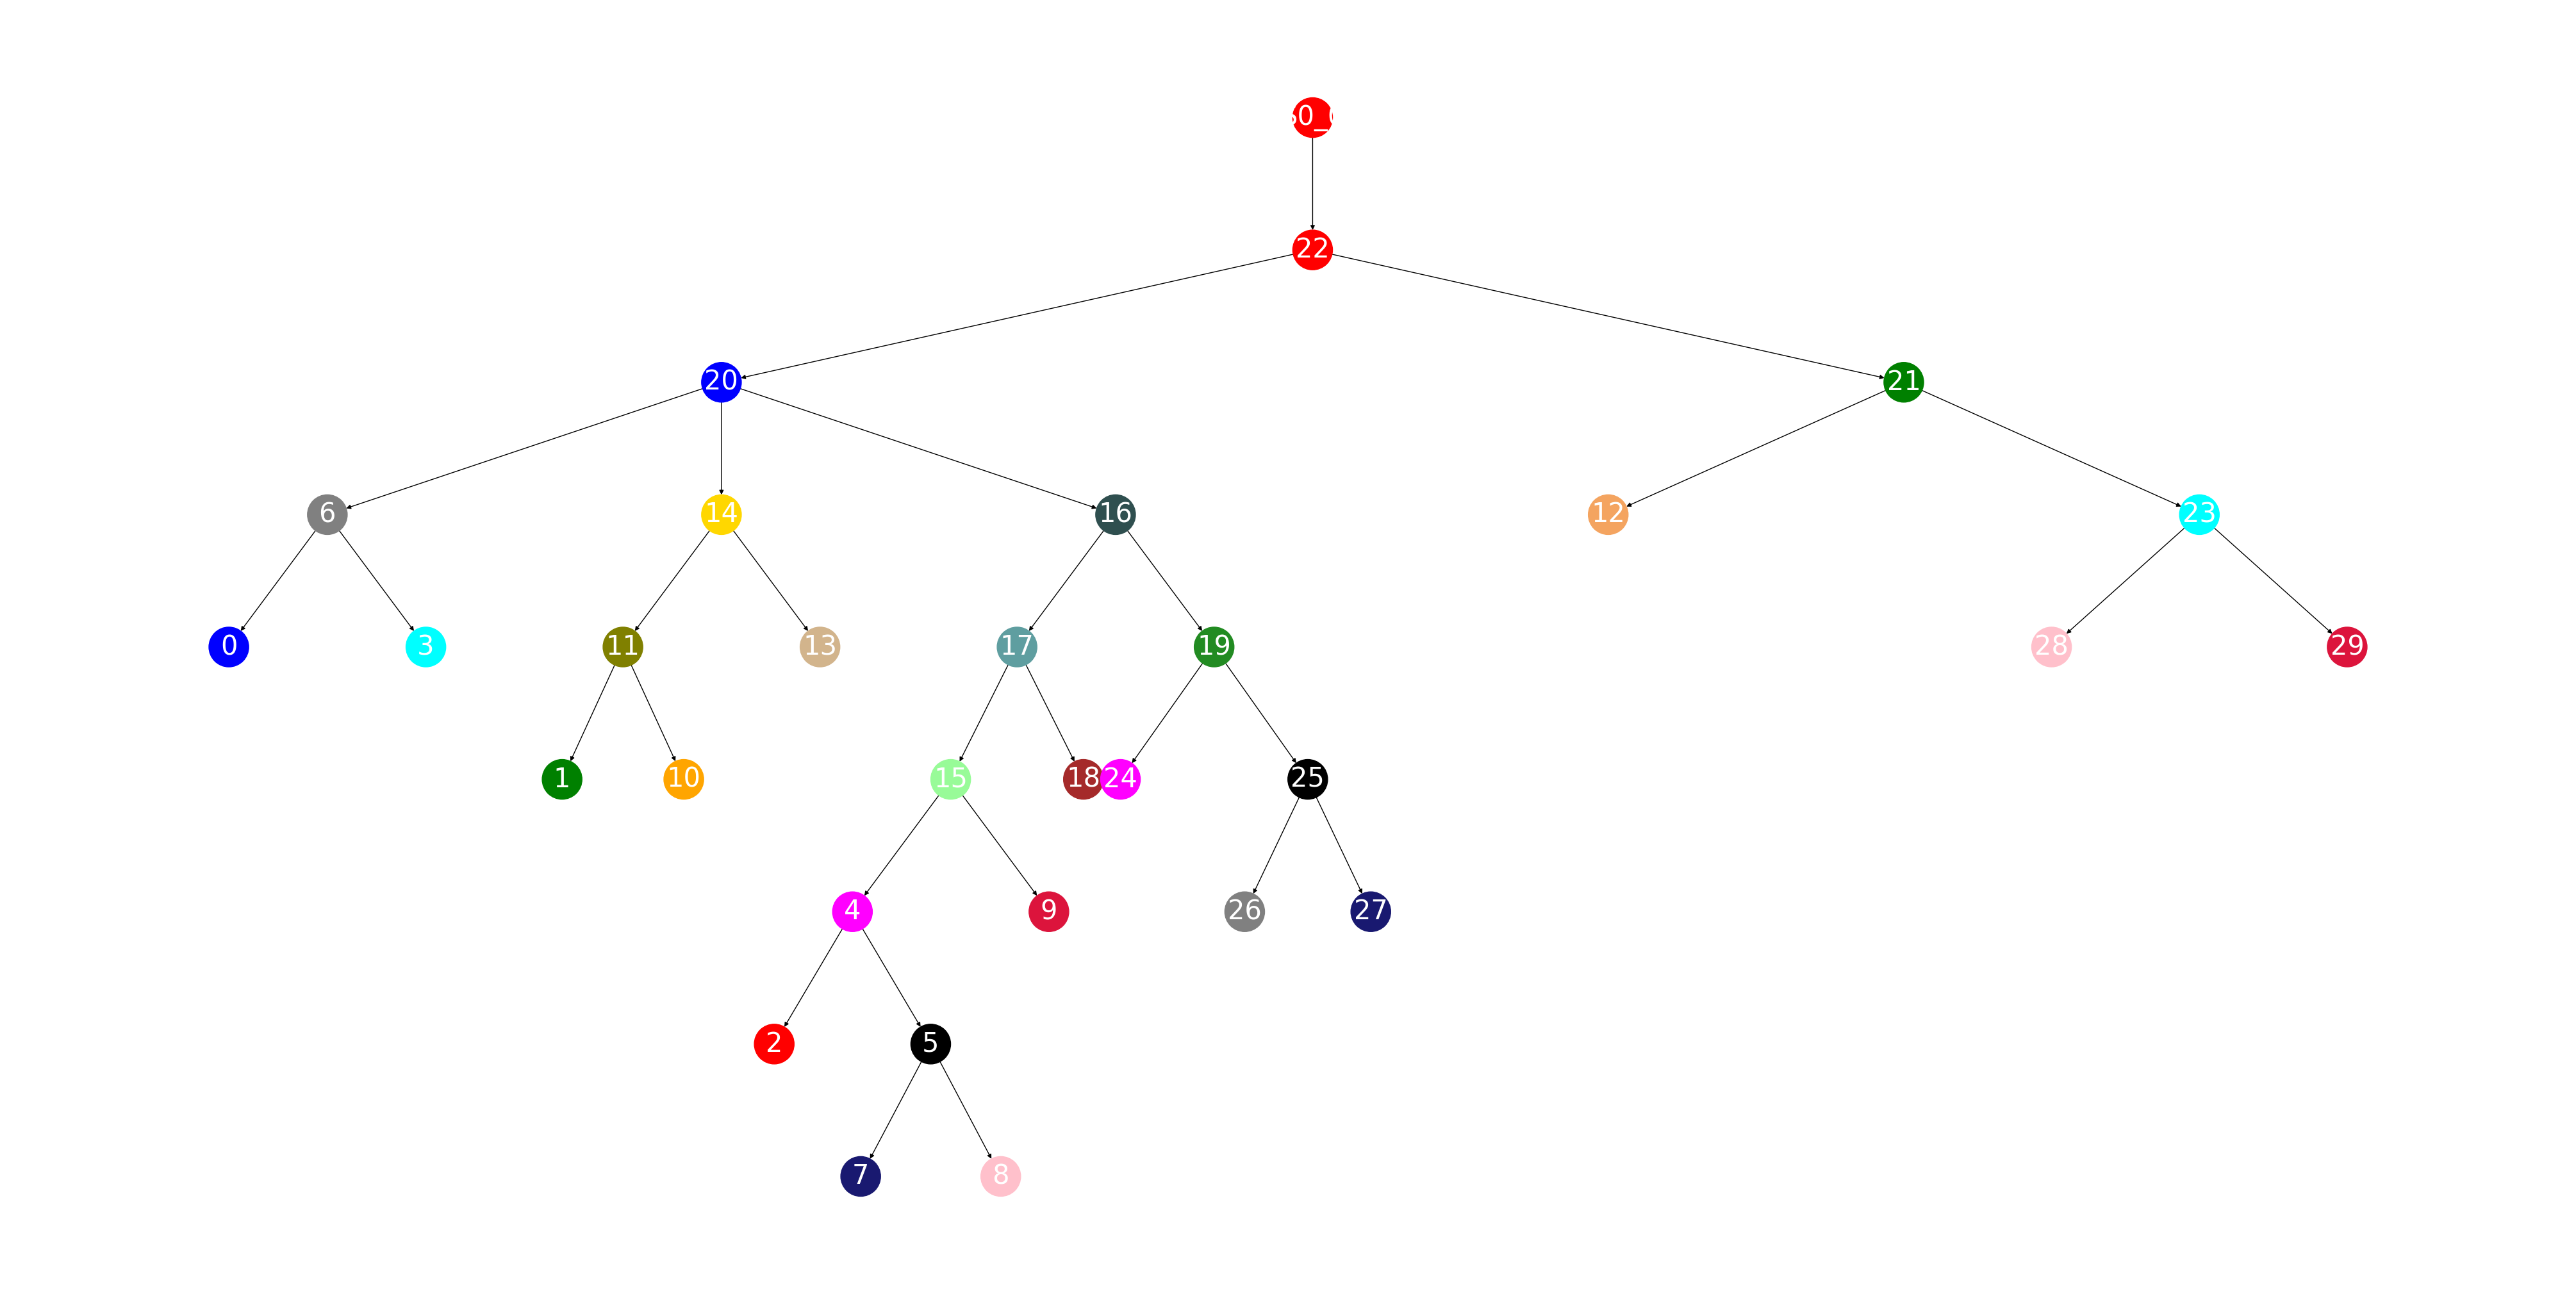

In [19]:
nviz.plot_limb(neuron_obj_rec,0)

In [20]:
branch_idx = 3
limb_idx = 0

branch_mesh = neuron_obj_rec[limb_idx][branch_idx].mesh
ipvu.plot_objects(branch_mesh)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [21]:
_ = branch_mesh.export(f"{segment_id}_limb_{limb_idx}_branch_{branch_idx}.off")

# Step 4A: Multi Soma Split Suggestions

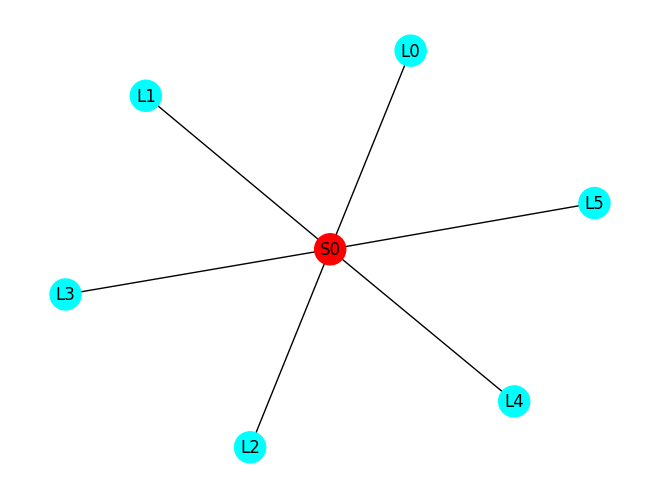

In [27]:
from neurd import neuron_visualizations as nviz
nviz.plot_soma_limb_concept_network(
    neuron_obj_rec
)

In [28]:
multi_soma_split_parameters = dict()

In [29]:
_ = neuron_obj_rec.calculate_multi_soma_split_suggestions(
    plot = True,
    store_in_obj = True,
    **multi_soma_split_parameters
)


In [30]:
neuron_obj_rec.pipeline_products.multi_soma_split_suggestions.multi_soma_split_parameters = multi_soma_split_parameters

# Step 4B: Multi Soma Split Execution

In [31]:
neuron_list = neuron_obj_rec.multi_soma_split_execution(
    verbose = False,
)

No error limbs to processs so just returning the original neuron


In [37]:
n1 = neuron_list[0]
print(n1)
print(n1.pipeline_products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691134917511946,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(15723, 3), faces.shape=(38825, 3))>, <trimesh.Trimesh(vertices.shape=(4348, 3), faces.shape=(8941, 3))>, <trimesh.Trimesh(vertices.shape=(1586, 3), faces.shape=(3510, 3))>, <trimesh.Trimesh(vertices.shape=(808, 3), faces.shape=(1812, 3))>, <trimesh.Trimesh(vertices.shape=(806, 3), faces.shape=(1809, 3))>, <trimesh.Trimesh(vertices.shape=(805, 3), faces.shape=(1808, 3))>, <trimesh.Trimesh(vertices.shape=(668, 3), faces.shape=(1502, 3))>, <trimesh.Trimesh(vertices.shape=(636, 3), faces.shape=(882, 3))>, <trimesh.Trimesh(vertices.shape=(534, 3), faces.shape=(1170, 3))>, <trimesh.Trimesh(vertices.shape=(2419, 3), faces.shape=(4893, 3))>, <trimesh.Trimesh(vertices.shape=(1665, 3), faces.shape=(2568, 3))>, <trimesh.Trimesh(vertices.shape=(1619, 3), faces

# Step 5: Cell Typing

In [33]:
from neurd import neuron_pipeline_utils as npu

In [34]:
neuron_obj_axon = npu.cell_type_ax_dendr_stage(
    n1,
    mesh_decimated = mesh_decimated,
    plot_axon = False,
)


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 3


Number of segments: 2


Number of segments: 5


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 3


Number of segments: 3


Number of segments: 2


Number of segments: 3


Number of segments: 3


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 1


Number of segments: 2


Number of segments: 1


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 3


Number of segments: 2


Number of segments: 1


Number of segments: 4


Number of segments: 4


Number of segments: 3


Number of segments: 3


Number of segments: 3


Number of segments: 2


Number of segments: 3


Number of segments: 3


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segme

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 2.6071150302886963
branches_touching_root = [16]
combining close nodes
combine_threshold = 1300
length of Graph = 13106
After combining close endpoints max(kept_branches_idx) = 230, len(kept_branches_idx) = 190
empty_indices % = 0.0
 conflict_indices % = 0.05154251788018087
Decomposing first pass: 24.493428230285645
Only Using MeshParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 1.3828277587890625e-05
Total time for MAP sublimb processing 5.0067901611328125e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 2.47955322265625e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.009846210479736328
sbv[0].reshape(-1,3) = [[ 552945.2  757231.5 1044509. ]]
closest_sk_pt_coord BEFORE = [ 552495.72569604  757785.38871569 1044811.89960749]


In [35]:
nviz.plot_axon(
    neuron_obj_axon
)


 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

# Autoproofreading Stage

In [36]:
print(neuron_obj_axon)
print(mesh_decimated)

<trimesh.Trimesh(vertices.shape=(420741, 3), faces.shape=(865980, 3), name=`864691134917511946.off`)>


About to do syn_density stats
syn_density_post = 0.8419744036477983
syn_density_head = 0.4098221746304416
syn_density_neck = 0.021016521775920085
syn_density_shaft = 0.3244425549157663
sk_length_synapse_density = 2283917.410872266
About to do spine_density stats
postsyn_limb_branch = {'L0': array([ 0,  1,  3,  4,  6,  9, 10, 11, 12, 13, 14, 15, 18, 19, 23, 24, 25,
       27]), 'L1': array([0, 1, 4, 7]), 'L2': array([ 6,  7, 14]), 'L4': array([0]), 'L5': array([0])}
sk_length = 2184969.390122509
# of spines = 1000
Density = 0.4576723154661361
spine_density = 0.4576723154661361 (multiplier = 1000)
sk_length spine density = 2184969.390122509
Done stats
Not apply_hand_made_low_rules
For model: LogisticRegression(class_weight={'excitatory': 1, 'inhibitory': 1.5}) 
with features: ['syn_density_shaft', 'spine_density']
pred_class = excitatory, pred_class_label = excitatory
Total time for e/i calculations = 0.2080824375152588
baylor_e_i = excitatory

*****Using v7 Filters!!!


Current node ski

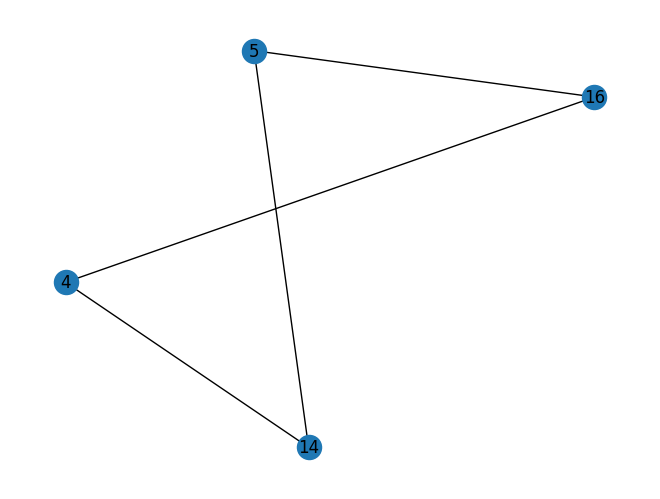

Performing global features query
Done with edge_df: 0.0012288093566894531
Performing Edge Query
After edge filter, # of rows = 2
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0   5  14     23.88   73.126074               0.421484              0.000335   
1   5  16     23.63    3.939240               0.022705              0.000335   
2  14   4     52.16    2.675122               0.025961              0.000000   
3  16   4     22.12   66.511712               0.645459              0.000000   

   n_synapses_diff  definite_partner_width_delete definite_partner_sk_delete  
0                1                           True                       None  
1                1                          False                       None  
2                0                          False                       None  
3                0                           True                       None  
Afer 

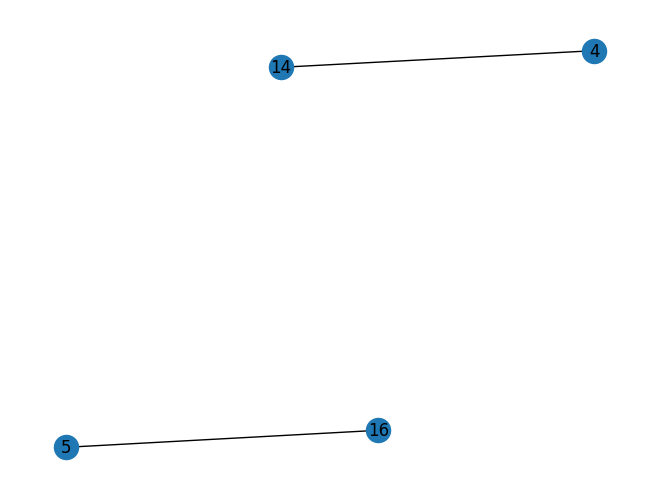

Performing node features query
Done with edge_df: 0.0011856555938720703
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0   5  16     23.63    3.939240               0.022705              0.000335   
1  14   4     52.16    2.675122               0.025961              0.000000   

   n_synapses_diff  definite_partner_width_delete definite_partner_sk_delete  \
0                1                          False                       None   
1                0                          False                       None   

  above_threshold_delete  
0                   None  
1                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0   5  16     23.63    3.939240               0.022705              0.000335   
1  14   4     52.16    2.675122               0.025961          

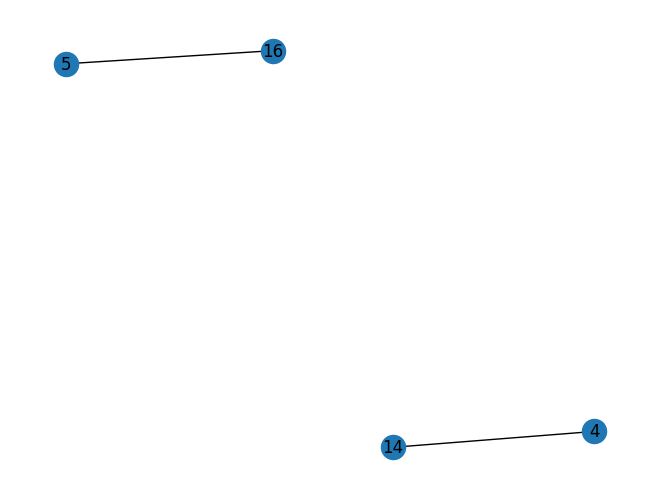

for upstream node 4, winning_node = 14, error_branches = [ 5 16]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (100.3705489424222) less than width_min(250)
Current node skip distance was 1889.5692620114319 but max skip distance was 2300.0
Current node skip distance was 1513.8828772852676 but max skip distance was 1513.8828772852676
Current node skip distance was 2300 but max skip distance was 2300.0
Current node skip distance was 1564.572460918915 but max skip distance was 1564.572460918915
Current node skip distance was 1555.4698732187237 but max skip distance was 1555.4698732187237
Current node skip distance was 1733.177959888325 but max skip distance was 1889.5692620114319
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0011203289031982422
Performing Edge Query
After edge filter, # of rows = 2
Exporting the edges
Deleteing edg

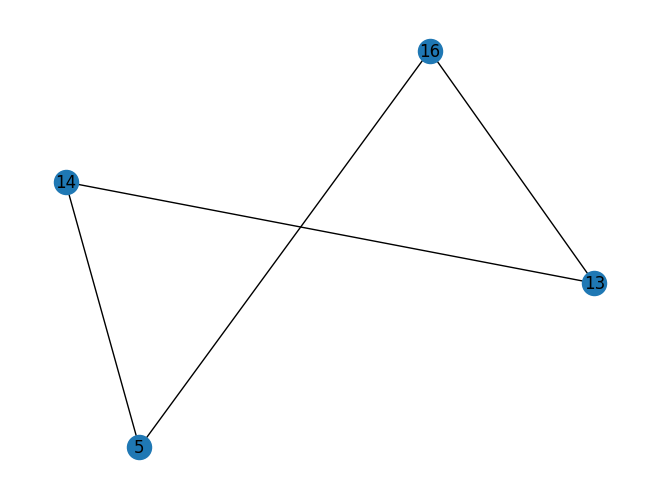

Performing global features query
Done with edge_df: 0.0011034011840820312
Performing Edge Query
After edge filter, # of rows = 2
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0   5  14     23.88   73.126074               0.421484              0.000335   
1   5  16     23.63    3.939240               0.022705              0.000335   
2  14  13     64.30   11.354489               0.101629              0.000000   
3  16  13     33.57   57.832345               0.517631              0.000000   

   n_synapses_diff  definite_partner_width_delete definite_partner_sk_delete  
0                1                           True                       None  
1                1                          False                       None  
2                0                          False                       None  
3                0                           True                       None  
Afer 

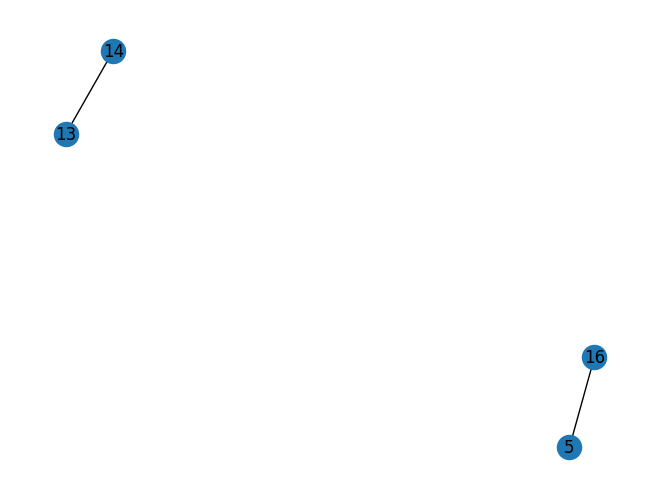

Performing node features query
Done with edge_df: 0.0012426376342773438
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0   5  16     23.63    3.939240               0.022705              0.000335   
1  14  13     64.30   11.354489               0.101629              0.000000   

   n_synapses_diff  definite_partner_width_delete definite_partner_sk_delete  \
0                1                          False                       None   
1                0                          False                       None   

  above_threshold_delete  
0                   None  
1                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0   5  16     23.63    3.939240               0.022705              0.000335   
1  14  13     64.30   11.354489               0.101629          

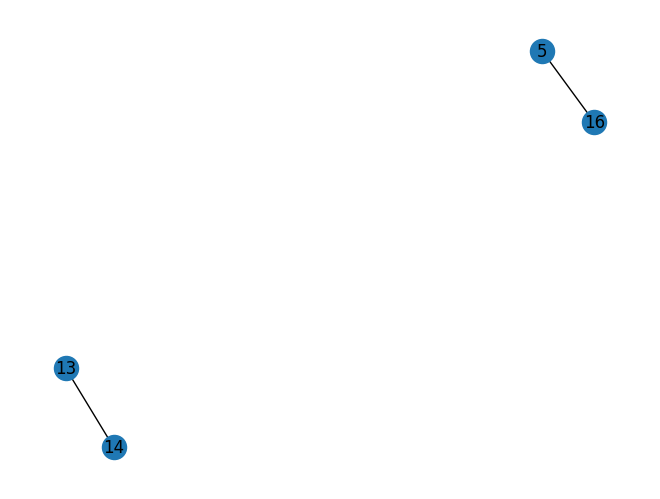

for upstream node 13, winning_node = 14, error_branches = [ 5 16]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (100.3705489424222) less than width_min(250)
Current node skip distance was 1584.8772872600919 but max skip distance was 1584.8772872600919
Current node skip distance was 1873.1557631602866 but max skip distance was 1873.1557631602866
Current node skip distance was 1700.9203354618562 but max skip distance was 2300.0
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.001957416534423828
Performing Edge Query
After edge filter, # of rows = 8
Exporting the edges
Deleteing edges only

--- Before Local Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0   0   2     83.24   80.583125               1.102563              0.000000   
1   0   4     63.12   38.637975               0.528657      

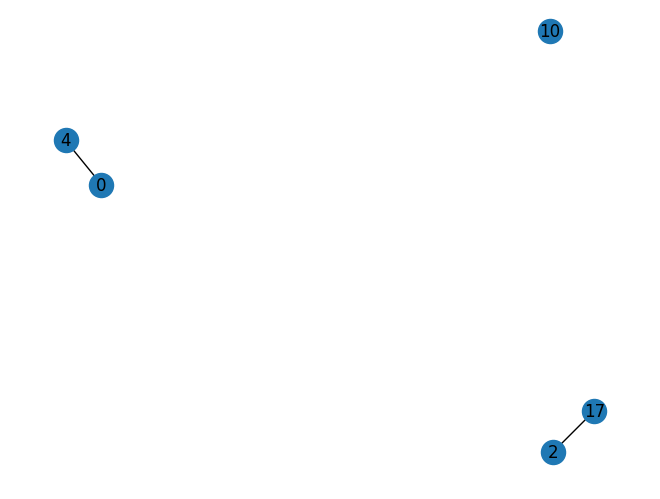

Performing global features query
Done with edge_df: 0.001020193099975586
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
   u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  0   4     63.12   38.637975               0.528657                   0.0   
1  2  17      2.31   25.449309               0.198480                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                0                       None                          None  
1                0                      False                          None  
Afer Global query: 
   u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  0   4     63.12   38.637975               0.528657                   0.0   
1  2  17      2.31   25.449309               0.198480                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_del

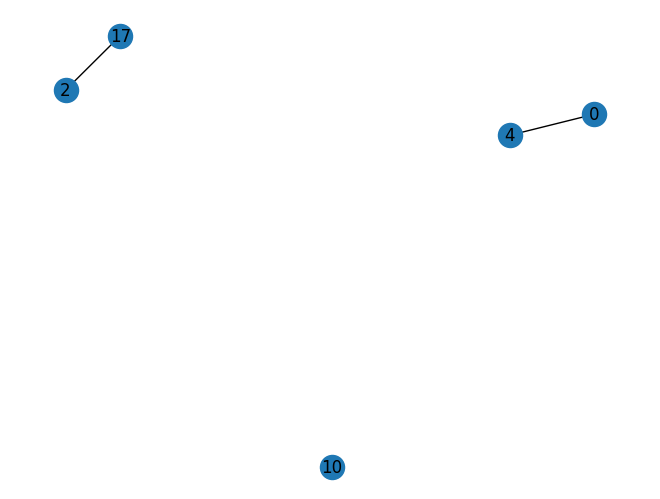

Performing node features query
Done with edge_df: 0.0016105175018310547
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
   u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  0   4     63.12   38.637975               0.528657                   0.0   
1  2  17      2.31   25.449309               0.198480                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                0                       None                          None   
1                0                      False                          None   

  above_threshold_delete  
0                   None  
1                   None  
Afer Node query: 
   u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  0   4     63.12   38.637975               0.528657                   0.0   
1  2  17      2.31   25.449309               0.198480                   

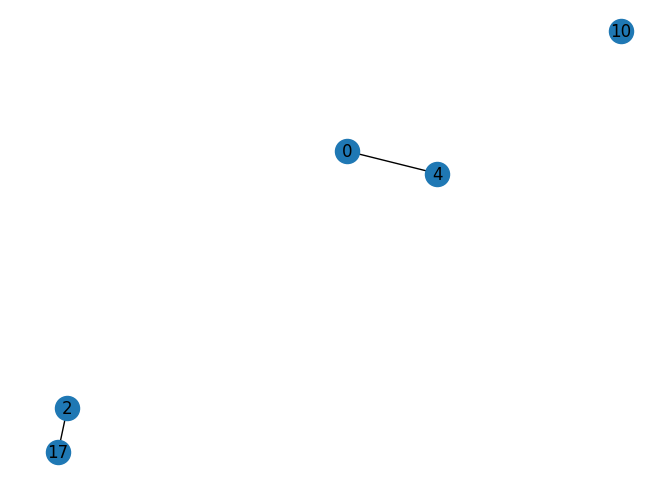

for upstream node 17, winning_node = 2, error_branches = [ 0  4 10]
Inside high_degree_false_positive_low_sibling_filter ****
Not exactly 2 downstream errors so returning
Current node skip distance was 1497.6150841524118 but max skip distance was 1497.6150841524118
Current node skip distance was 1780.438368687568 but max skip distance was 1780.438368687568
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.002669811248779297
Performing Edge Query
After edge filter, # of rows = 4
Exporting the edges
Deleteing edges only

--- Before Local Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  17  20     25.83   54.719755               0.426762              0.000000   
1  17  21     70.64    1.648374               0.012856              0.000189   
2  17  19     56.33   19.084328               0.129556              0.000000  

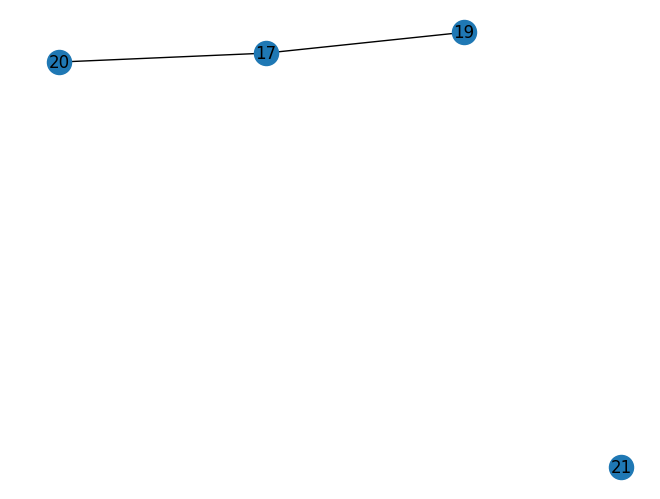

Performing global features query
Done with edge_df: 0.0026345252990722656
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  17  20     25.83   54.719755               0.426762                   0.0   
1  17  19     56.33   19.084328               0.129556                   0.0   

   n_synapses_diff  definite_partner_sk_delete definite_partner_width_delete  
0                0                       False                          None  
1                0                        True                          None  
Afer Global query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  17  20     25.83   54.719755               0.426762                   0.0   

   n_synapses_diff  definite_partner_sk_delete definite_partner_width_delete  
0                0                       False                 

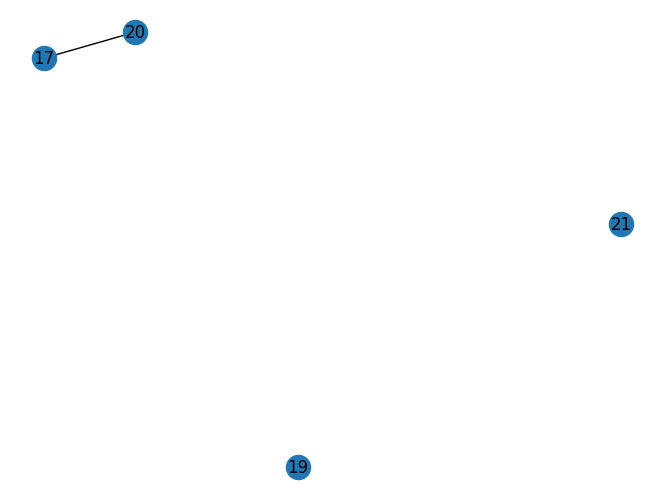

Performing node features query
Done with edge_df: 0.003312349319458008
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  17  20     25.83   54.719755               0.426762                   0.0   

   n_synapses_diff  definite_partner_sk_delete definite_partner_width_delete  \
0                0                       False                          None   

  above_threshold_delete  
0                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  17  20     25.83   54.719755               0.426762                   0.0   

   n_synapses_diff  definite_partner_sk_delete definite_partner_width_delete  \
0                0                       False                          None   

  above_threshold_delete  
0                   None  


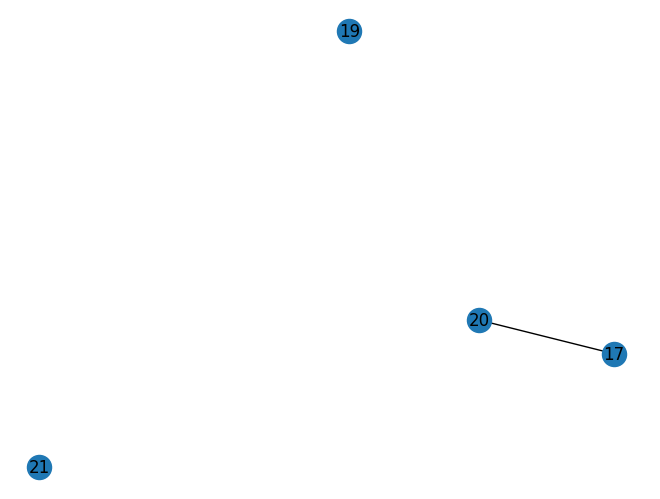

Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1472.9213556462194 but max skip distance was 1472.9213556462194
Current node skip distance was 1707.788560665129 but max skip distance was 1823.9865420987066
Current node skip distance was 1628.36603139084 but max skip distance was 1628.36603139084
Current node skip distance was 1480.048301990361 but max skip distance was 1480.048301990361
Current node skip distance was 1533.0137920093266 but max skip distance was 1533.0137920093266
Current node skip distance was 1705.6569378562172 but max skip distance was 1780.438368687568
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0013687610626220703
Performing Edge Query
After edge filter, # of rows = 9
Exporting the edges
Deleteing edges only

--- Before Local Query ---
     u   v  sk_angle  wid

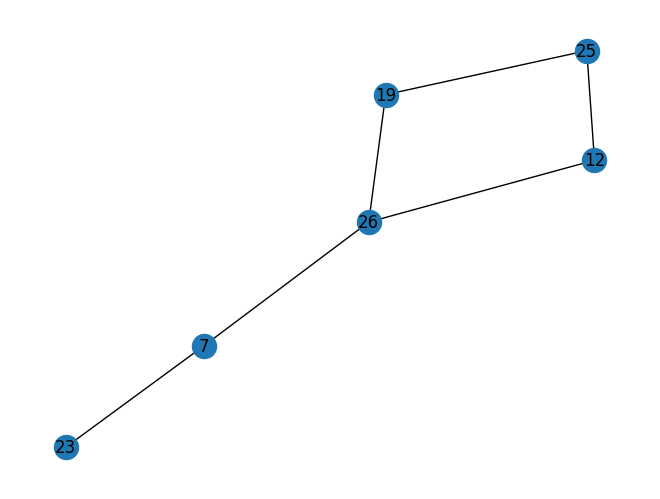

Performing global features query
Done with edge_df: 0.0011706352233886719
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0   7  23     13.03    8.120298               0.097445              0.000084   
1   7  26     45.19   13.405755               0.160872              0.000197   
2  12  26     29.39   23.386634               0.250626              0.000281   
3  12  25     43.29   36.044896               0.278645              0.000278   
4  19  26     59.91   77.379073               0.525298              0.000281   
5  19  25     32.65   17.947543               0.138744              0.000278   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                1                      False                          None  
1                1                       True                          None  
2     

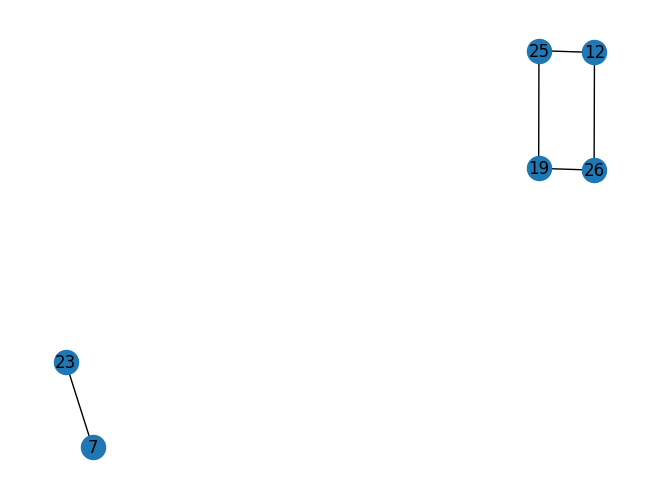

Performing node features query
Done with edge_df: 0.001439809799194336
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0   7  23     13.03    8.120298               0.097445              0.000084   
1  12  26     29.39   23.386634               0.250626              0.000281   
2  12  25     43.29   36.044896               0.278645              0.000278   
3  19  26     59.91   77.379073               0.525298              0.000281   
4  19  25     32.65   17.947543               0.138744              0.000278   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                1                      False                          None   
1                2                       None                          None   
2                1                       None                          None   
3        

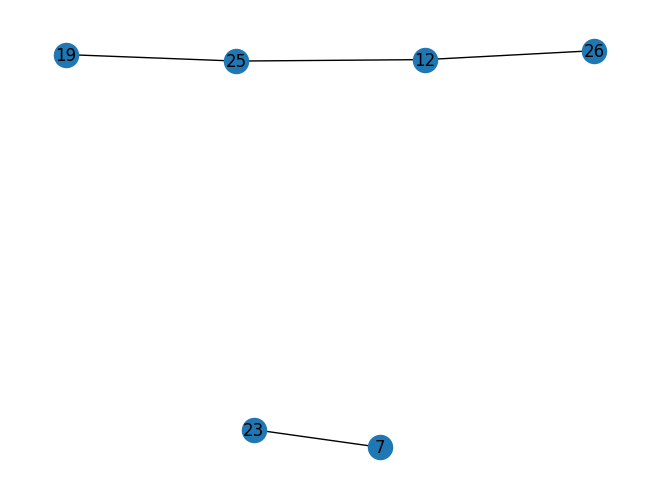

for upstream node 25, winning_node = None, error_branches = [ 7 12 19 23 26]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1458.0255655002047 but max skip distance was 1458.0255655002047
Current node skip distance was 1473.9583068018837 but max skip distance was 1473.9583068018837
Current node skip distance was 1439.2097328140164 but max skip distance was 1439.2097328140164
Current node skip distance was 1665.7633897842265 but max skip distance was 1705.6569378562172
Current node skip distance was 1849.468203499803 but max skip distance was 1849.468203499803
Current node skip distance was 1373.696244750608 but max skip distance was 1373.696244750608
Current node skip distance was 2051.8343766422095 but max skip distance was 2051.8343766422095
Current node skip distance was 1404.8838081237627 but max skip distance was 1404.8838081237627
Current node skip distance was 1452.7036445270596 but max skip distance was 14

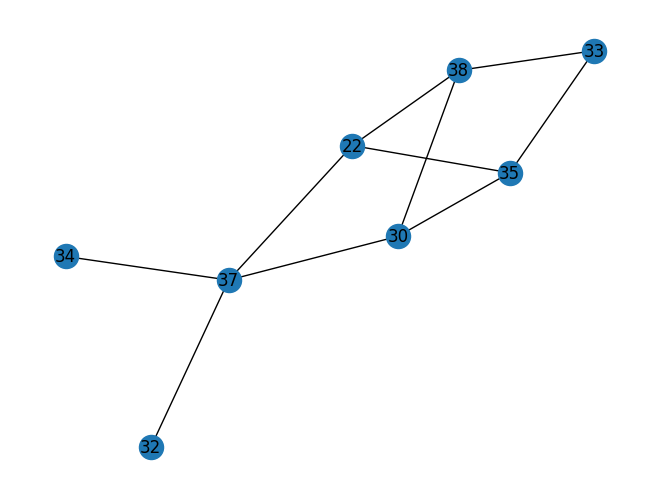

Performing global features query
Done with edge_df: 0.0012581348419189453
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  22  35     41.68   53.635734               0.484043              0.000000   
1  22  38     33.53   51.967919               0.468991              0.000000   
2  22  37     57.51   40.847335               0.269343              0.000197   
3  30  35     22.18   62.611100               0.522703              0.000000   
4  30  38     26.36   60.943285               0.508780              0.000000   
5  30  37     21.22   31.871969               0.210161              0.000197   
6  32  37     34.81   12.217186               0.080559              0.000197   
7  33  35     35.68    7.485015               0.150643              0.000000   
8  33  38     44.63    9.152830               0.184209              0.000000   
9

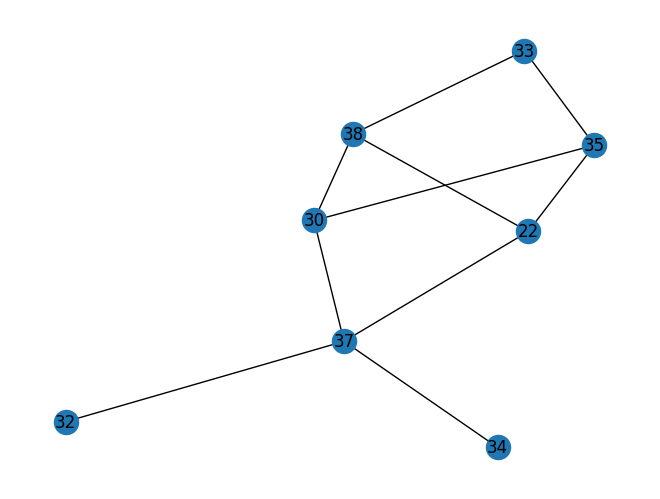

Performing node features query
Done with edge_df: 0.0013513565063476562
Performing Edge Query
After edge filter, # of rows = 2
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  22  35     41.68   53.635734               0.484043              0.000000   
1  22  38     33.53   51.967919               0.468991              0.000000   
2  22  37     57.51   40.847335               0.269343              0.000197   
3  30  35     22.18   62.611100               0.522703              0.000000   
4  30  38     26.36   60.943285               0.508780              0.000000   
5  30  37     21.22   31.871969               0.210161              0.000197   
6  32  37     34.81   12.217186               0.080559              0.000197   
7  33  35     35.68    7.485015               0.150643              0.000000   
8  33  38     44.63    9.152830               0.184209              0.000000   
9  34

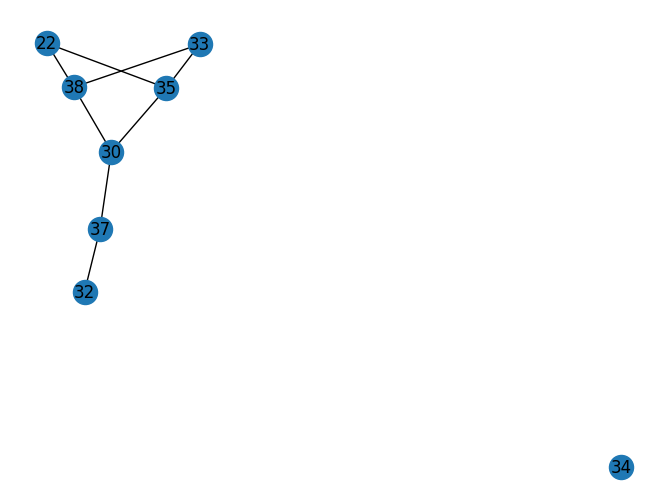

for upstream node 37, winning_node = None, error_branches = [22 30 32 33 34 35 38]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1411.8330370166711 but max skip distance was 1411.8330370166711
Current node skip distance was 1420.3496711923483 but max skip distance was 1420.3496711923483
Current node skip distance was 1567.6425816995368 but max skip distance was 1567.6425816995368
Current node skip distance was 1617.3603515870936 but max skip distance was 2300.0
Current node skip distance was 1763.4735386570042 but max skip distance was 1763.4735386570042
Current node skip distance was 1806.1698114568526 but max skip distance was 2194.6320494015
Current node skip distance was 1537.784737637764 but max skip distance was 1537.784737637764
Current node skip distance was 1413.411712631187 but max skip distance was 1413.411712631187
Current node skip distance was 1542.8876169858418 but max skip distance was 1763.473538

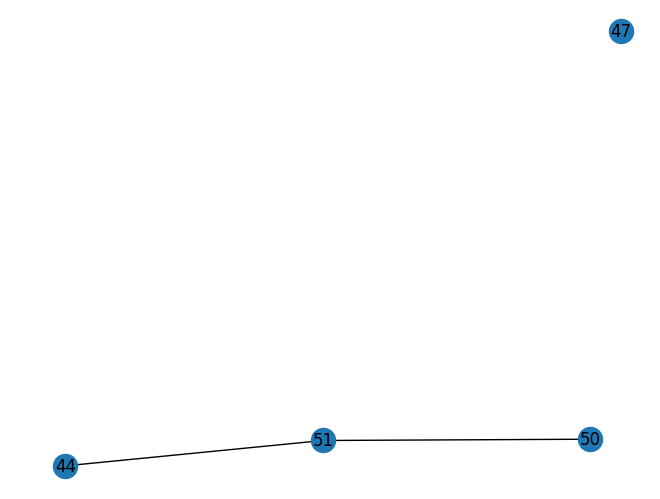

Performing global features query
Done with edge_df: 0.0013971328735351562
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  44  51     43.30  141.860633               0.497592              0.000244   
1  50  51     38.68  112.871744               0.395910              0.000012   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                5                       None                          None  
1                2                       None                          None  
Afer Global query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  44  51     43.30  141.860633               0.497592              0.000244   
1  50  51     38.68  112.871744               0.395910              0.000012   

   n_synapses_diff definite_partner_sk_delete definite_partner_wi

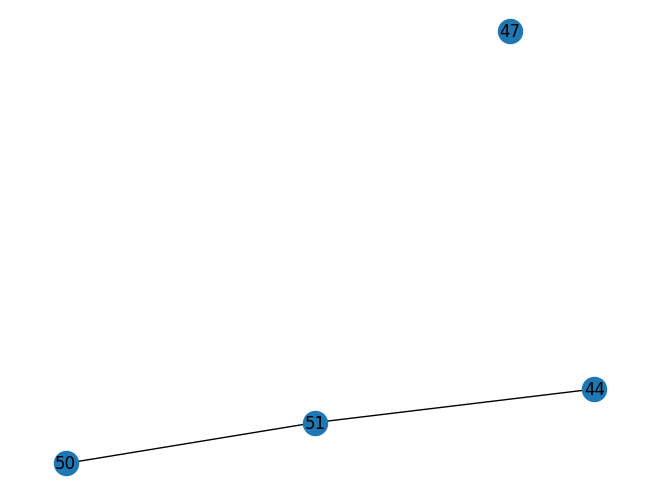

Performing node features query
Done with edge_df: 0.0016467571258544922
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  44  51     43.30  141.860633               0.497592              0.000244   
1  50  51     38.68  112.871744               0.395910              0.000012   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                5                       None                          None   
1                2                       None                          None   

  above_threshold_delete  
0                   None  
1                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  44  51     43.30  141.860633               0.497592              0.000244   
1  50  51     38.68  112.871744               0.395910             

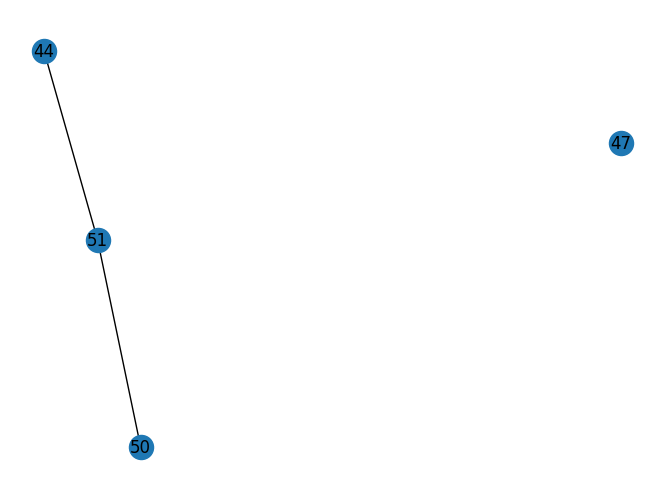

for upstream node 51, winning_node = None, error_branches = [44 47 50]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1384.062406158812 but max skip distance was 1384.062406158812
Current node skip distance was 1393.3073677849236 but max skip distance was 1393.3073677849236
Current node skip distance was 1815.575740570935 but max skip distance was 2300.0
Current node skip distance was 2056.2983971366075 but max skip distance was 2056.2983971366075
Current node skip distance was 1575.4758694553161 but max skip distance was 2056.2983971366075
Current node skip distance was 1932.9598162227605 but max skip distance was 1932.9598162227605
Current node skip distance was 2190.5126252904165 but max skip distance was 2300.0
Current node skip distance was 2067.895075421905 but max skip distance was 2190.5126252904165
Current node skip distance was 1606.498192758714 but max skip distance was 1606.498192758714
Current node sk

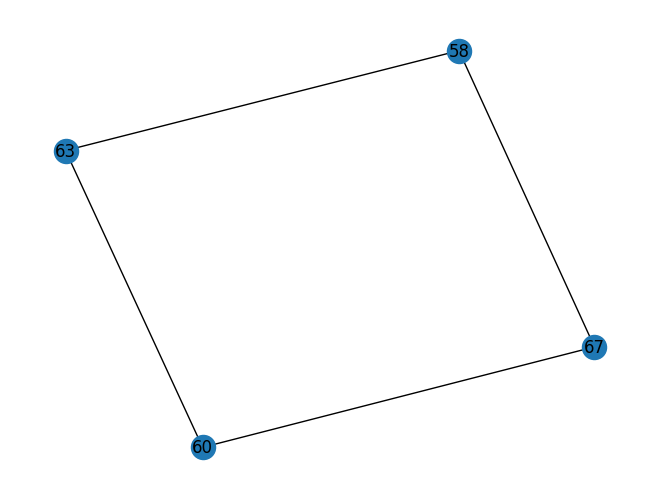

Performing global features query
Done with edge_df: 0.0011348724365234375
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  58  63     17.13   73.825110               0.752441              0.000199   
1  58  67     16.34   42.415010               0.301823              0.000000   
2  60  63     30.88   67.771701               0.650602              0.000199   
3  60  67     21.11   36.361601               0.258748              0.000000   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                3                       None                          None  
1                0                       None                          None  
2                3                       None                          None  
3                0                       None                          None  
Afer Globa

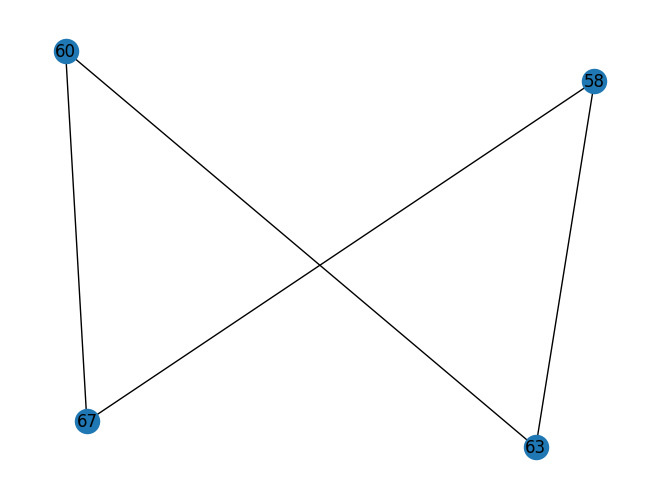

Performing node features query
Done with edge_df: 0.001310586929321289
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  58  63     17.13   73.825110               0.752441              0.000199   
1  58  67     16.34   42.415010               0.301823              0.000000   
2  60  63     30.88   67.771701               0.650602              0.000199   
3  60  67     21.11   36.361601               0.258748              0.000000   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                3                       None                          None   
1                0                       None                          None   
2                3                       None                          None   
3                0                       None                          None   

  above_t

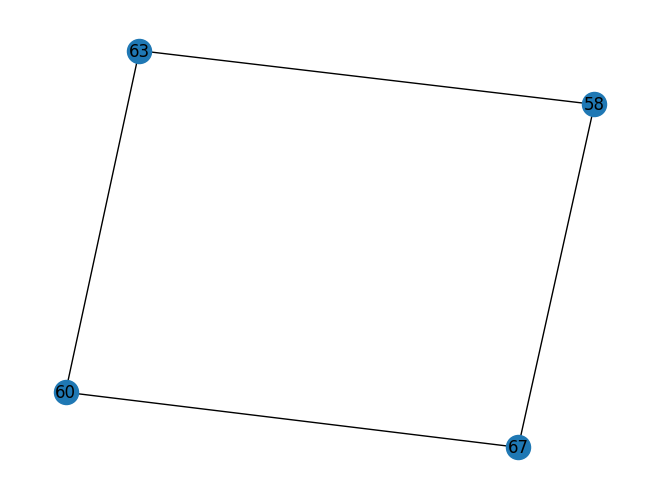

for upstream node 67, winning_node = None, error_branches = [58 60 63]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1953.9356343413888 but max skip distance was 1953.9356343413888
Current node skip distance was 1656.7132565072902 but max skip distance was 1953.9356343413888
Current node skip distance was 2300 but max skip distance was 2300.0
Current node skip distance was 1450.8454232028087 but max skip distance was 1450.8454232028087
Current node skip distance was 1527.1977673222736 but max skip distance was 1527.1977673222736
Current node skip distance was 1777.2547339923053 but max skip distance was 1777.2547339923053
Current node skip distance was 1545.8807480142711 but max skip distance was 1736.1818925166326
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0035538673400878906
P

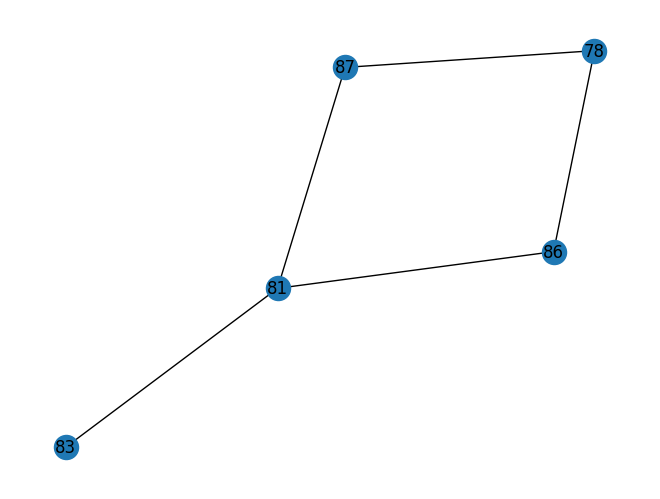

Performing global features query
Done with edge_df: 0.0027887821197509766
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  81  83     16.49   52.873283               0.630868                   0.0   
1  81  86     23.95    3.354177               0.040021                   0.0   
2  81  87     49.84   14.337994               0.171077                   0.0   
3  86  78     51.57    3.846831               0.042268                   0.0   
4  87  78     33.58   21.539002               0.236663                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                0                       None                          None  
1                0                       None                          None  
2                0                       None                          None  
3       

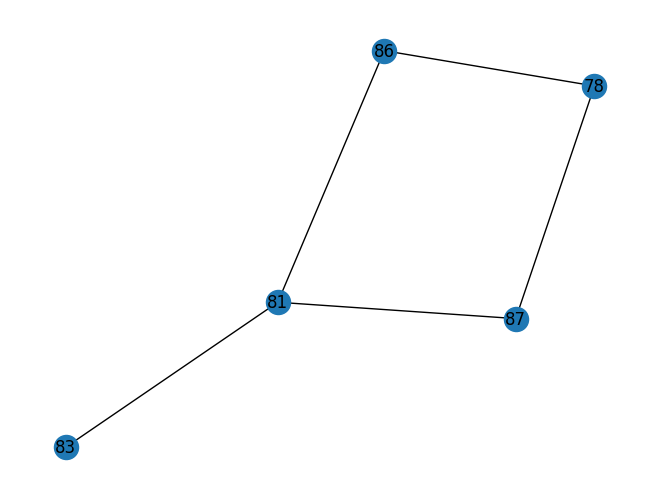

Performing node features query
Done with edge_df: 0.0015408992767333984
Performing Edge Query
After edge filter, # of rows = 2
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  81  83     16.49   52.873283               0.630868                   0.0   
1  81  86     23.95    3.354177               0.040021                   0.0   
2  81  87     49.84   14.337994               0.171077                   0.0   
3  86  78     51.57    3.846831               0.042268                   0.0   
4  87  78     33.58   21.539002               0.236663                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                0                       None                          None   
1                0                       None                          None   
2                0                       None                          None   
3       

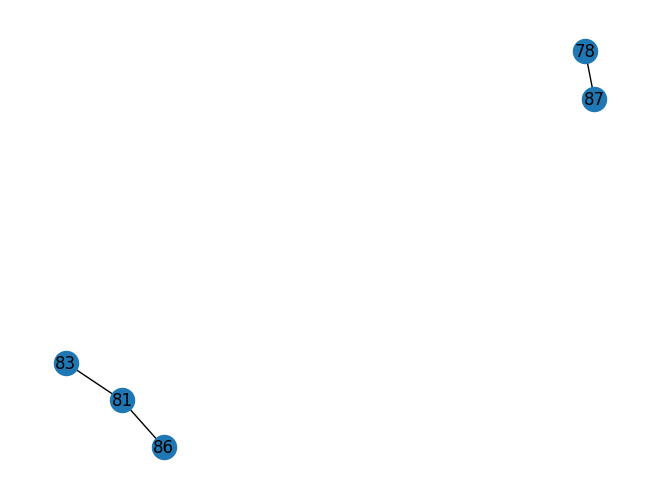

for upstream node 78, winning_node = 87, error_branches = [81 83 86]
Inside high_degree_false_positive_low_sibling_filter ****
Not exactly 2 downstream errors so returning
Current node skip distance was 1800.28352975214 but max skip distance was 1815.575740570935
Current node skip distance was 1496.9905664249613 but max skip distance was 1496.9905664249613
Current node skip distance was 1515.8765468973068 but max skip distance was 1515.8765468973068
Current node skip distance was 2111.9029827320123 but max skip distance was 2111.9029827320123
Current node skip distance was 1736.1818925166326 but max skip distance was 1736.1818925166326
Current node skip distance was 1336.8129747715132 but max skip distance was 2111.9029827320123
Current node skip distance was 1529.8522860692512 but max skip distance was 1529.8522860692512
Current node skip distance was 1456.1349055998858 but max skip distance was 1711.9329196747517
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 

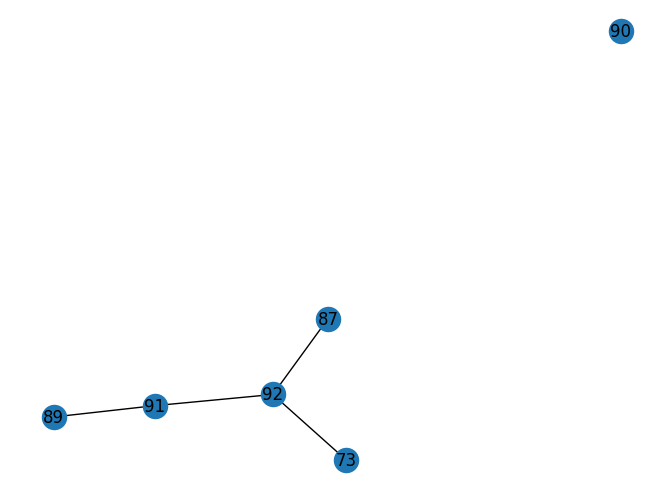

Performing global features query
Done with edge_df: 0.0011322498321533203
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  73  92     10.84    5.038227               0.073871              0.000174   
1  89  91     64.64   41.530596               0.317357              0.000000   
2  91  92     49.21   16.092176               0.180136              0.000000   
3  92  87     12.25    3.768751               0.054248              0.000000   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                2                       None                          None  
1                0                       None                          None  
2                0                       None                          None  
3                0                       None                          None  
Afer Globa

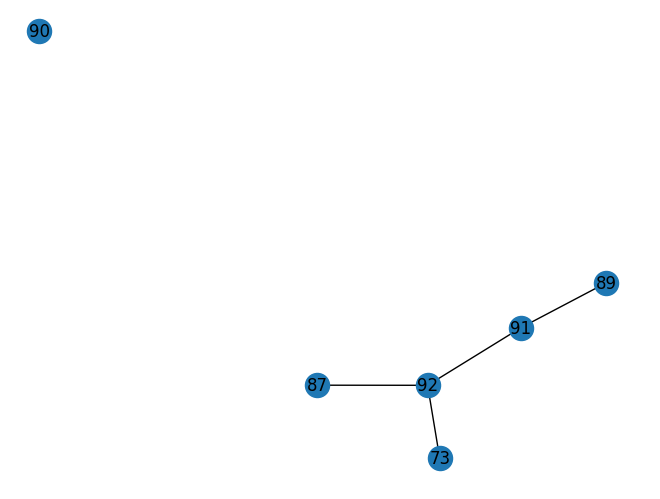

Performing node features query
Done with edge_df: 0.0010824203491210938
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  73  92     10.84    5.038227               0.073871              0.000174   
1  89  91     64.64   41.530596               0.317357              0.000000   
2  91  92     49.21   16.092176               0.180136              0.000000   
3  92  87     12.25    3.768751               0.054248              0.000000   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                2                       None                          None   
1                0                       None                          None   
2                0                       None                          None   
3                0                       None                          None   

  above_

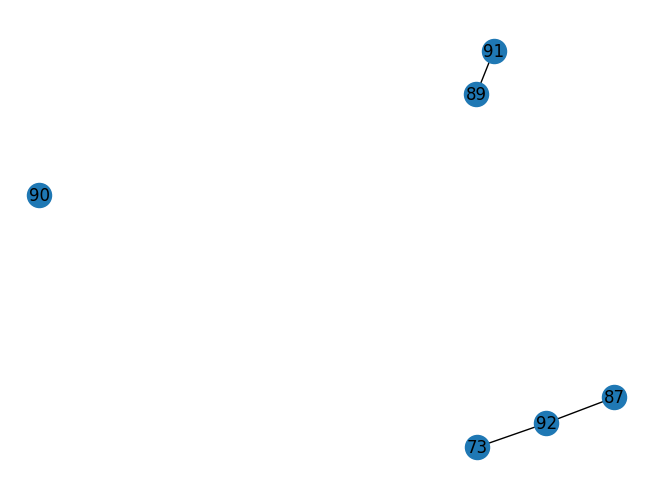

for upstream node 87, winning_node = None, error_branches = [73 89 90 91 92]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1558.6216205458122 but max skip distance was 1777.2547339923053
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0021185874938964844
Performing Edge Query
After edge filter, # of rows = 4
Exporting the edges
Deleteing edges only

--- Before Local Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  69  77    112.54   28.929955               0.245980              0.000000   
1  69  82     40.65   73.787434               0.627385              0.000248   
2  69  88     77.03   23.541993               0.250263              0.000112   
3  77  82    101.75   44.857479               0.306108              0.000248   
4  77  88     5

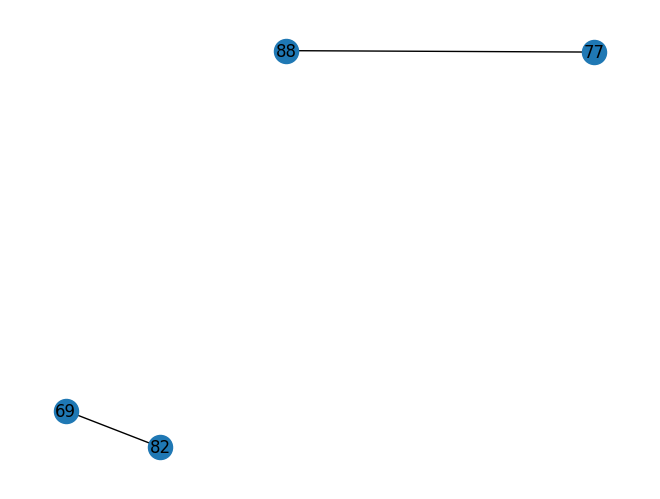

Performing global features query
Done with edge_df: 0.003010988235473633
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  69  82     40.65   73.787434               0.627385              0.000248   
1  77  88     58.28   52.471947               0.557802              0.000112   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                1                      False                          None  
1                7                       None                          None  
Afer Global query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  69  82     40.65   73.787434               0.627385              0.000248   
1  77  88     58.28   52.471947               0.557802              0.000112   

   n_synapses_diff definite_partner_sk_delete definite_partner_wid

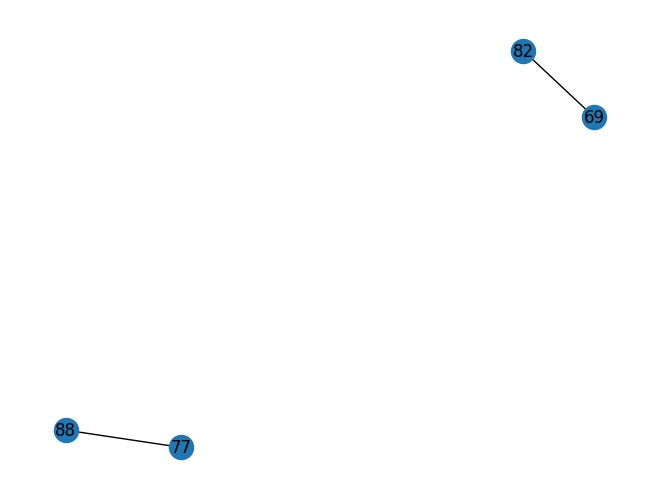

Performing node features query
Done with edge_df: 0.0014705657958984375
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  69  82     40.65   73.787434               0.627385              0.000248   
1  77  88     58.28   52.471947               0.557802              0.000112   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                1                      False                          None   
1                7                       None                          None   

  above_threshold_delete  
0                   None  
1                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  69  82     40.65   73.787434               0.627385              0.000248   
1  77  88     58.28   52.471947               0.557802             

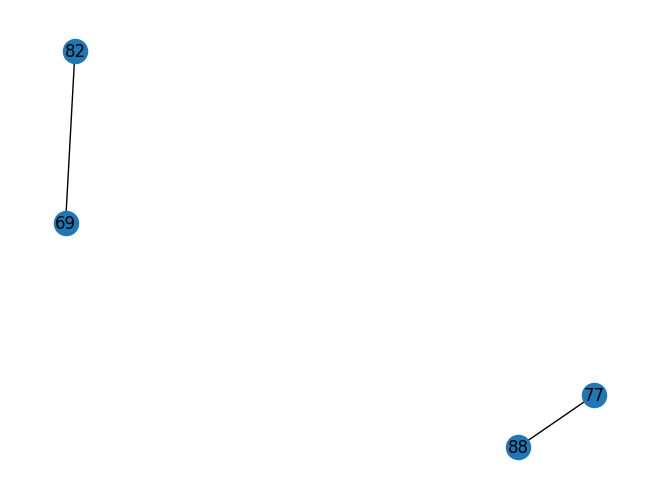

for upstream node 88, winning_node = 77, error_branches = [69 82]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (146.54113615815348) less than width_min(250)
Current node skip distance was 1711.9329196747517 but max skip distance was 1711.9329196747517
Current node skip distance was 1620.3701772285754 but max skip distance was 1620.3701772285754
Current node skip distance was 1538.8887713219233 but max skip distance was 1538.8887713219233
Current node skip distance was 1471.8380360714896 but max skip distance was 1471.8380360714896
Current node skip distance was 1529.1076968233356 but max skip distance was 1738.280348791949
Current node skip distance was 2259.586494072186 but max skip distance was 2259.586494072186
Current node skip distance was 1500.1006314943045 but max skip distance was 2259.586494072186
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff <

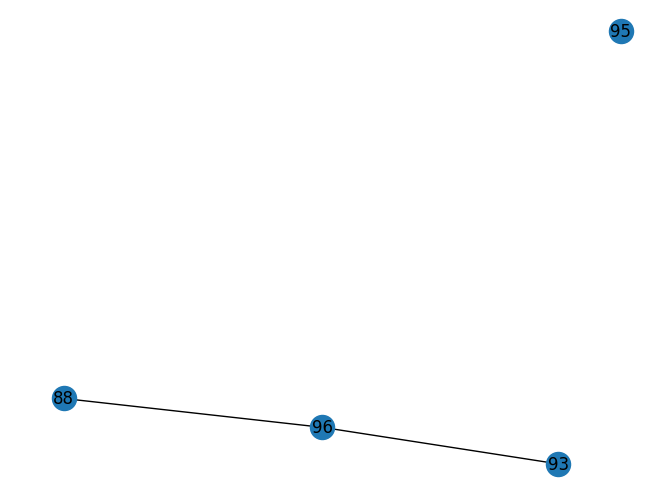

Performing global features query
Done with edge_df: 0.002404928207397461
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  88  96     14.33   14.045037               0.175510              0.000091   
1  93  96     50.91    6.961696               0.086995              0.000020   

   n_synapses_diff  definite_partner_sk_delete definite_partner_width_delete  
0                6                       False                          None  
1                1                        True                          None  
Afer Global query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  88  96     14.33   14.045037                0.17551              0.000091   

   n_synapses_diff  definite_partner_sk_delete definite_partner_width_delete  
0                6                       False                  

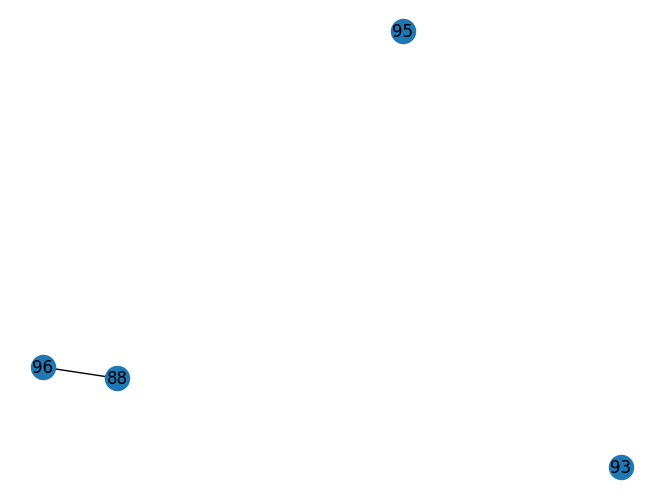

Performing node features query
Done with edge_df: 0.0020503997802734375
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  88  96     14.33   14.045037                0.17551              0.000091   

   n_synapses_diff  definite_partner_sk_delete definite_partner_width_delete  \
0                6                       False                          None   

  above_threshold_delete  
0                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  88  96     14.33   14.045037                0.17551              0.000091   

   n_synapses_diff  definite_partner_sk_delete definite_partner_width_delete  \
0                6                       False                          None   

  above_threshold_delete  
0                   None  


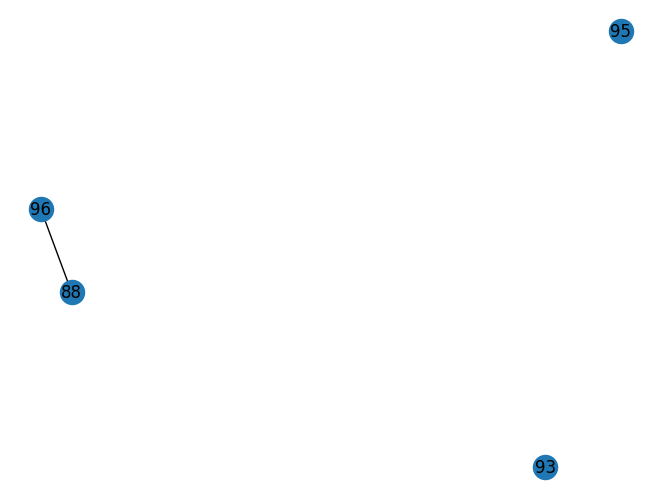

for upstream node 96, winning_node = 88, error_branches = [93 95]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (97.55504075401218) less than width_min(250)
Current node skip distance was 1607.3858060855919 but max skip distance was 1987.0475794936974
Current node skip distance was 1529.5449883497408 but max skip distance was 1529.5449883497408
Current node skip distance was 1714.031247526074 but max skip distance was 1714.031247526074
Current node skip distance was 1987.0475794936974 but max skip distance was 1987.0475794936974
Current node skip distance was 1587.8480419026057 but max skip distance was 1793.1204510958955
Current node skip distance was 1474.7194784132298 but max skip distance was 1532.930768923265
Current node skip distance was 1517.7243823465901 but max skip distance was 1517.7243823465901
Current node skip distance was 2300 but max skip distance was 2300.0
Current node skip distance was 1570.9882872584376 but max skip distance was 1570.9882

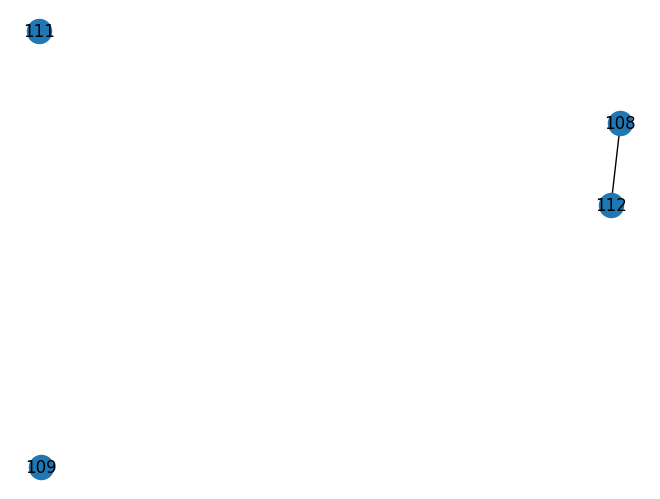

Performing global features query
Done with edge_df: 0.0015215873718261719
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  112  108     41.37   42.203666               0.413685   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000124                1                       False   

  definite_partner_width_delete  
0                          None  
Afer Global query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  112  108     41.37   42.203666               0.413685   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000124                1                       False   

  definite_partner_width_delete  
0                          None  


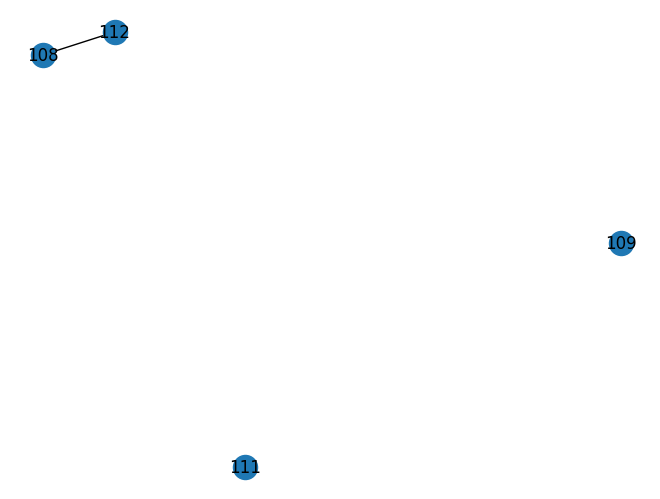

Performing node features query
Done with edge_df: 0.0013217926025390625
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  112  108     41.37   42.203666               0.413685   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000124                1                       False   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  
Afer Node query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  112  108     41.37   42.203666               0.413685   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000124                1                       False   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  


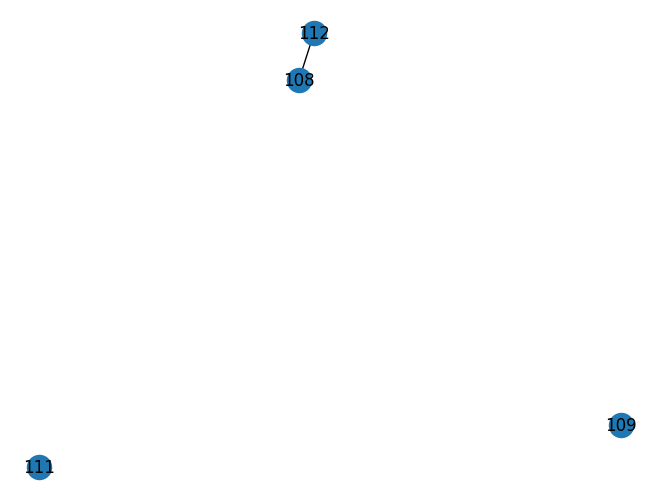

for upstream node 108, winning_node = 112, error_branches = [109 111]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (59.81510376025246) less than width_min(250)
Current node skip distance was 1558.5661985162365 but max skip distance was 1558.5661985162365
Current node skip distance was 1781.239046371689 but max skip distance was 1781.239046371689
Current node skip distance was 1463.7042418842564 but max skip distance was 1463.7042418842564
Current node skip distance was 1415.8962656677181 but max skip distance was 1415.8962656677181
Current node skip distance was 1519.0395242468926 but max skip distance was 1519.0395242468926
Current node skip distance was 1729.3895599488656 but max skip distance was 1729.3895599488656
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0010204315185546875
Performing Edge Query
After edge filter, # o

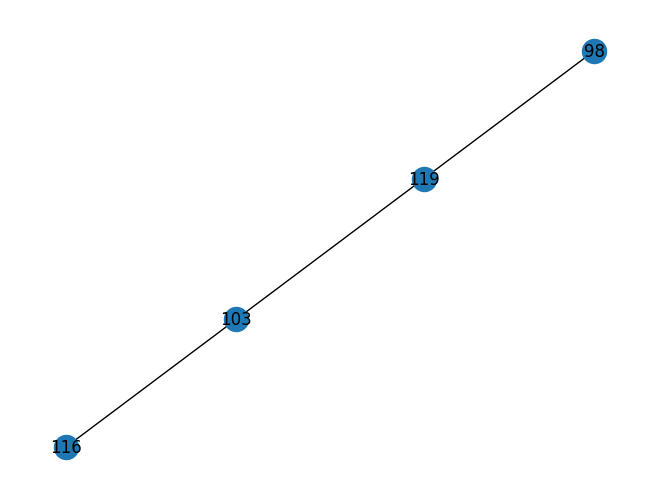

Performing global features query
Done with edge_df: 0.0014493465423583984
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0   98  119     51.47   10.531367               0.120924   
1  103  119     40.55   24.524100               0.242612   
2  103  116     41.01   33.969964               0.251530   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000075                1                       None   
1              0.000109                2                       None   
2              0.000000                0                       None   

  definite_partner_width_delete  
0                          None  
1                          None  
2                          None  
Afer Global query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0   98  119     51.47   10.531367               0.120924   

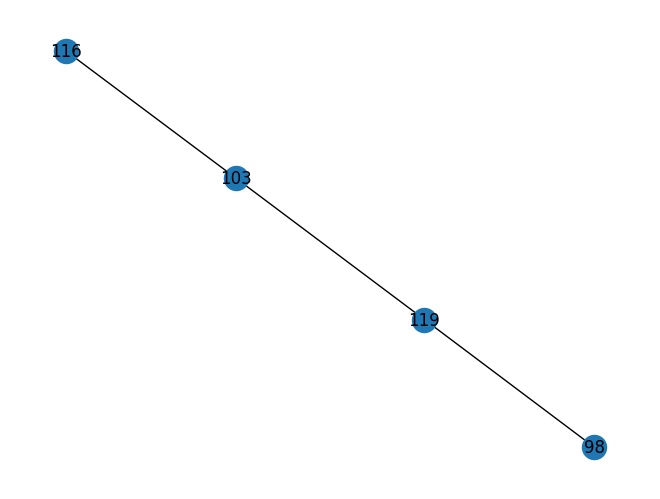

Performing node features query
Done with edge_df: 0.0029480457305908203
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0   98  119     51.47   10.531367               0.120924   
1  103  119     40.55   24.524100               0.242612   
2  103  116     41.01   33.969964               0.251530   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000075                1                       None   
1              0.000109                2                       None   
2              0.000000                0                       None   

  definite_partner_width_delete above_threshold_delete  
0                          None                   True  
1                          None                   None  
2                          None                   None  
Afer Node query: 
     u    v  sk_angle  width_diff

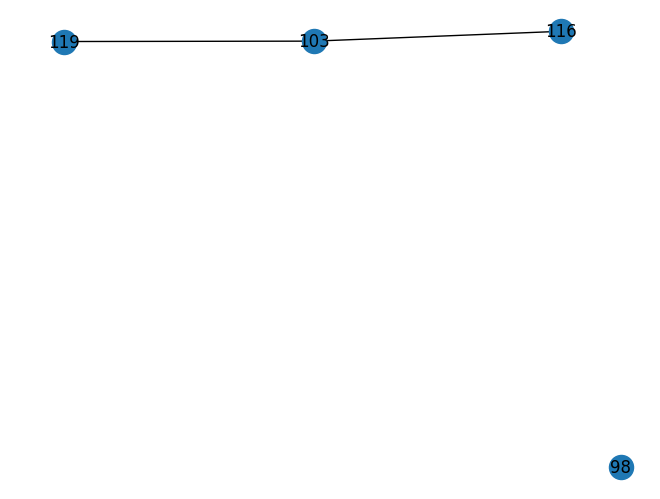

for upstream node 116, winning_node = None, error_branches = [ 98 103 119]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1666.3268224574595 but max skip distance was 2200.1446059728514
Current node skip distance was 1692.7289275802364 but max skip distance was 2124.525970877305
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0011048316955566406
Performing Edge Query
After edge filter, # of rows = 5
Exporting the edges
Deleteing edges only

--- Before Local Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  108  120     94.45   45.655389               0.447519   
1  108  122     75.40   39.451274               0.386706   
2  108  118     56.28   24.236172               0.191962   
3  120  122    159.93    6.204114               0.110073   
4  120  118    140.15  

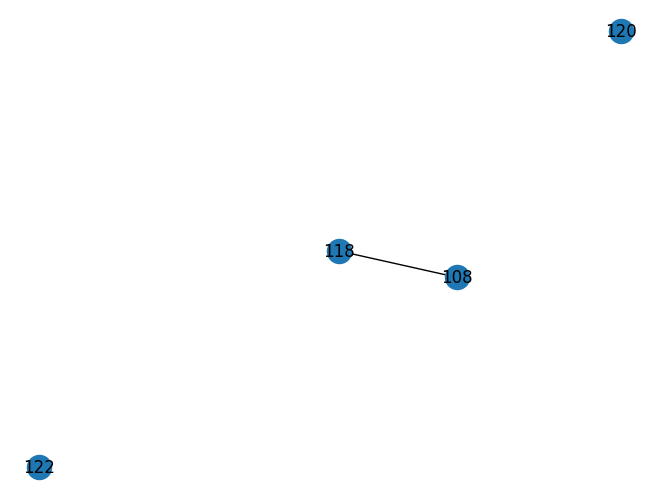

Performing global features query
Done with edge_df: 0.0017902851104736328
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  108  118     56.28   24.236172               0.191962   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000124                1                       None   

  definite_partner_width_delete  
0                          None  
Afer Global query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  108  118     56.28   24.236172               0.191962   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000124                1                       None   

  definite_partner_width_delete  
0                          None  


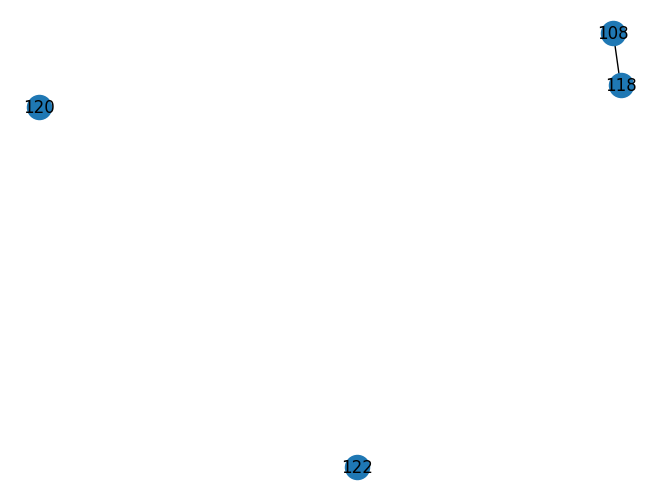

Performing node features query
Done with edge_df: 0.001310586929321289
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  108  118     56.28   24.236172               0.191962   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000124                1                       None   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  
Afer Node query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  108  118     56.28   24.236172               0.191962   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000124                1                       None   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  


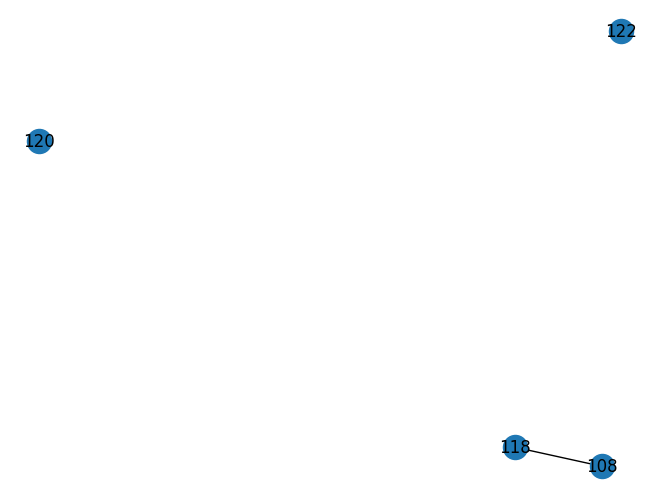

for upstream node 118, winning_node = 108, error_branches = [120 122]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (106.43417239106225) less than width_min(250)
Current node skip distance was 1485.6642933551425 but max skip distance was 1558.868122651933
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.002100229263305664
Performing Edge Query
After edge filter, # of rows = 4
Exporting the edges
Deleteing edges only

--- Before Local Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  149  151     30.73   19.842334               0.210801   
1  149  152     73.40   16.673394               0.177135   
2  149  119     96.83   17.568919               0.229481   
3  151  152    115.64    3.168939               0.042659   
4  151  119     68.71    2.273415               0.029695   
5  152  119     12.83    0.895525 

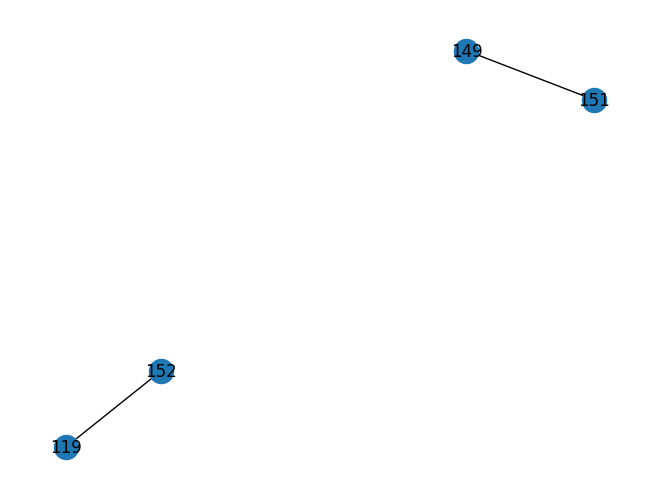

Performing global features query
Done with edge_df: 0.0024385452270507812
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  149  151     30.73   19.842334               0.210801   
1  152  119     12.83    0.895525               0.011697   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000000                0                       False   
1              0.000016                2                       False   

  definite_partner_width_delete  
0                          None  
1                         False  
Afer Global query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  149  151     30.73   19.842334               0.210801   
1  152  119     12.83    0.895525               0.011697   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000000     

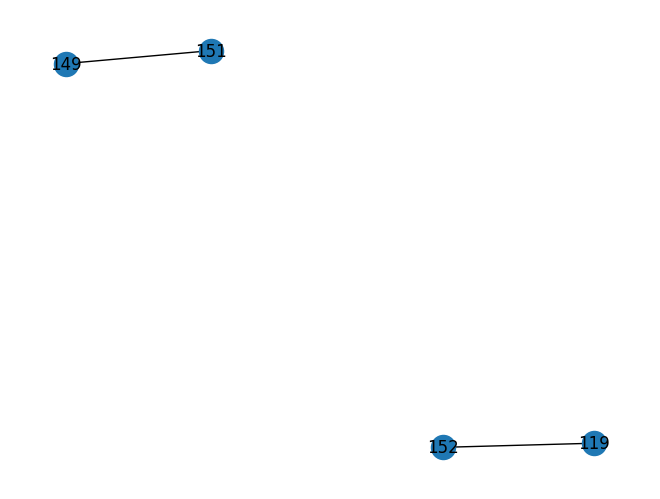

Performing node features query
Done with edge_df: 0.0014204978942871094
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  149  151     30.73   19.842334               0.210801   
1  152  119     12.83    0.895525               0.011697   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000000                0                       False   
1              0.000016                2                       False   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  
1                         False                   None  
Afer Node query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  149  151     30.73   19.842334               0.210801   
1  152  119     12.83    0.895525               0.011697   

   synapse_density_diff  n_synapses_d

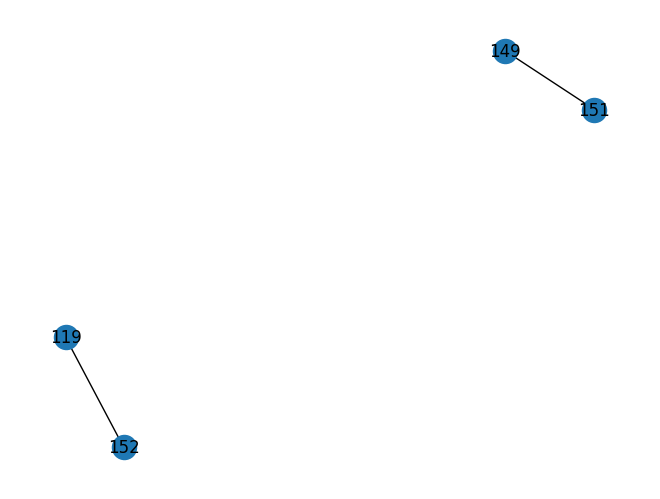

for upstream node 119, winning_node = 152, error_branches = [149 151]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (86.65776251469174) less than width_min(250)
Current node skip distance was 1401.514089053542 but max skip distance was 1666.3268224574595
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.002110004425048828
Performing Edge Query
After edge filter, # of rows = 3
Exporting the edges
Deleteing edges only

--- Before Local Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  117  134     50.97   18.914907               0.199453   
1  117  135     26.31   17.276162               0.182173   
2  117  120    129.50   38.470291               0.682541   
3  134  135    107.21    1.638744               0.021585   
4  134  120     66.14   19.555384               0.346952   
5  135  120     38.50   21.194128  

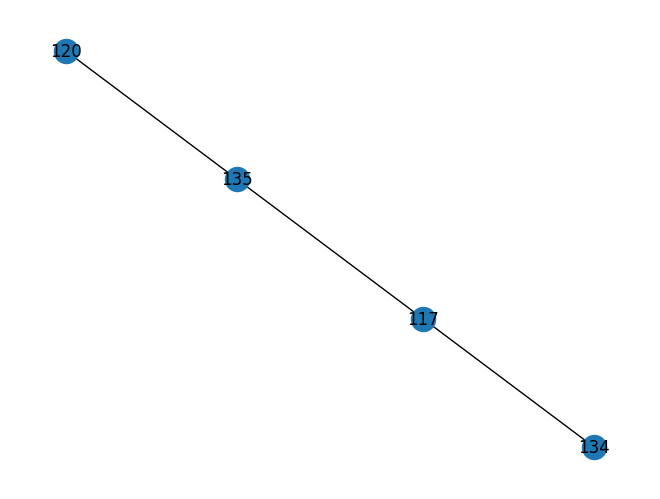

Performing global features query
Done with edge_df: 0.0026459693908691406
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  117  134     50.97   18.914907               0.199453   
1  117  135     26.31   17.276162               0.182173   
2  135  120     38.50   21.194128               0.376027   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000119                1                       None   
1              0.000032                0                       None   
2              0.000086                1                       None   

  definite_partner_width_delete  
0                          None  
1                          None  
2                          None  
Afer Global query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  117  134     50.97   18.914907               0.199453   

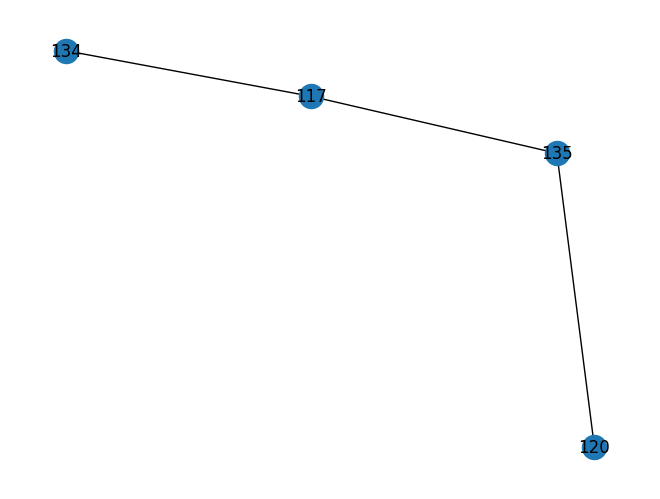

Performing node features query
Done with edge_df: 0.0010669231414794922
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  117  134     50.97   18.914907               0.199453   
1  117  135     26.31   17.276162               0.182173   
2  135  120     38.50   21.194128               0.376027   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000119                1                       None   
1              0.000032                0                       None   
2              0.000086                1                       None   

  definite_partner_width_delete above_threshold_delete  
0                          None                   True  
1                          None                   None  
2                          None                   None  
Afer Node query: 
     u    v  sk_angle  width_diff

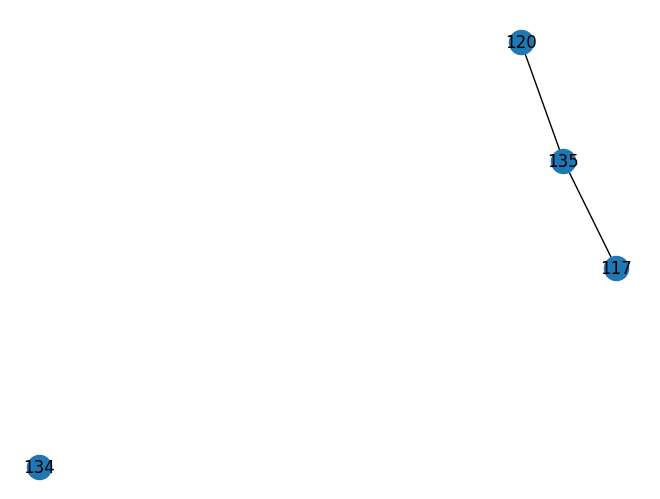

for upstream node 120, winning_node = None, error_branches = [117 134 135]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 2222.4913642393867 but max skip distance was 2222.4913642393867
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0010437965393066406
Performing Edge Query
After edge filter, # of rows = 4
Exporting the edges
Deleteing edges only

--- Before Local Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  110  123     76.31    4.385891               0.029735   
1  110  124     29.09   86.029616               0.583262   
2  110  121     82.29  145.849086               0.497191   
3  123  124     83.10   81.643725               0.570490   
4  123  121     26.58  150.234977               0.512142   
5  124  121    122.22  231.878702               0.790460 

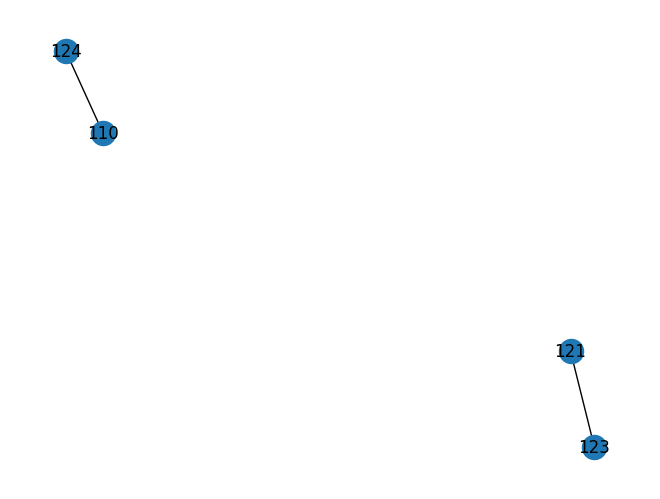

Performing global features query
Done with edge_df: 0.0015566349029541016
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  110  124     29.09   86.029616               0.583262   
1  123  121     26.58  150.234977               0.512142   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000107                1                       False   
1              0.000000                0                       False   

  definite_partner_width_delete  
0                          None  
1                          None  
Afer Global query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  110  124     29.09   86.029616               0.583262   
1  123  121     26.58  150.234977               0.512142   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000107     

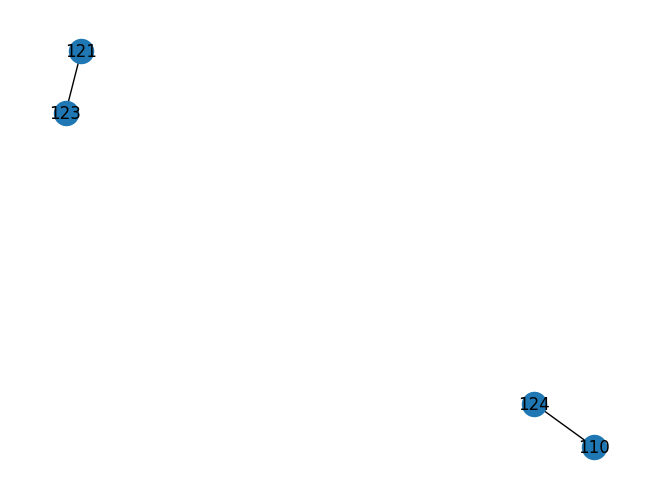

Performing node features query
Done with edge_df: 0.0010690689086914062
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  110  124     29.09   86.029616               0.583262   
1  123  121     26.58  150.234977               0.512142   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000107                1                       False   
1              0.000000                0                       False   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  
1                          None                   None  
Afer Node query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  110  124     29.09   86.029616               0.583262   
1  123  121     26.58  150.234977               0.512142   

   synapse_density_diff  n_synapses_d

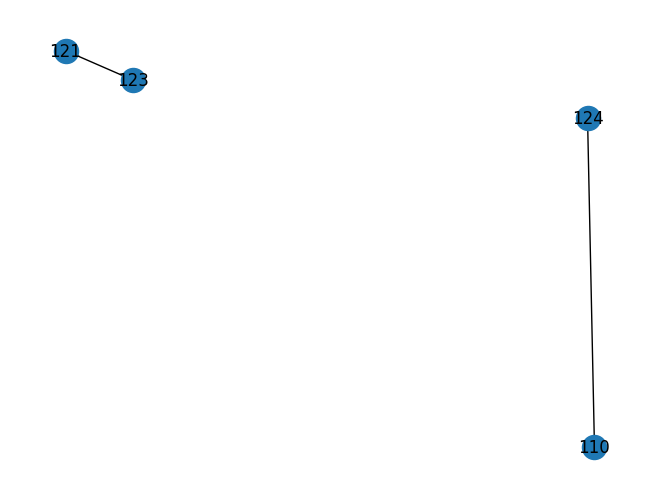

for upstream node 121, winning_node = 123, error_branches = [110 124]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (143.11148024633857) less than width_min(250)
Current node skip distance was 1427.364565567501 but max skip distance was 1427.364565567501
Current node skip distance was 1762.9645010264098 but max skip distance was 2097.618787294158
Current node skip distance was 1422.7823118140598 but max skip distance was 1422.7823118140598
Current node skip distance was 1446.194460318215 but max skip distance was 1446.194460318215
Current node skip distance was 2097.618787294158 but max skip distance was 2097.618787294158
Current node skip distance was 1556.065657251308 but max skip distance was 1556.065657251308
Current node skip distance was 1550.1241718840056 but max skip distance was 2142.1063878645527
Current node skip distance was 1449.235144763992 but max skip distance was 1449.235144763992
Current node skip distance was 1906.2663347269172 but max skip

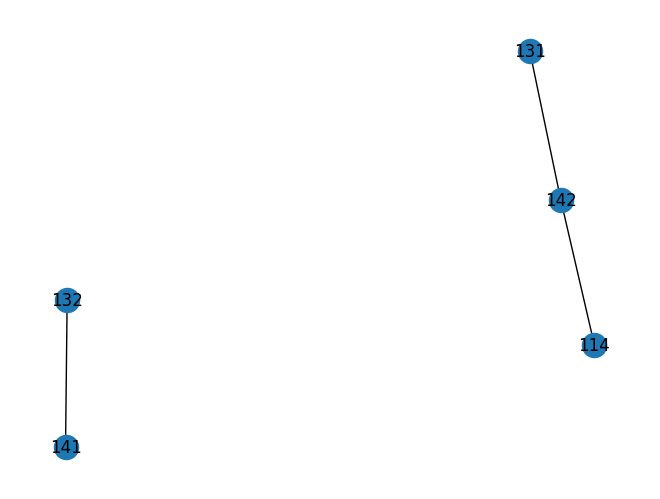

Performing global features query
Done with edge_df: 0.002912759780883789
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  114  142     14.12   31.335422               0.370529   
1  131  142     14.97   14.582371               0.215027   
2  141  132      6.99   82.430546               0.464387   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0                   0.0                0                       None   
1                   0.0                0                       None   
2                   0.0                0                      False   

  definite_partner_width_delete  
0                          None  
1                          None  
2                          None  
Afer Global query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  114  142     14.12   31.335422               0.370529   


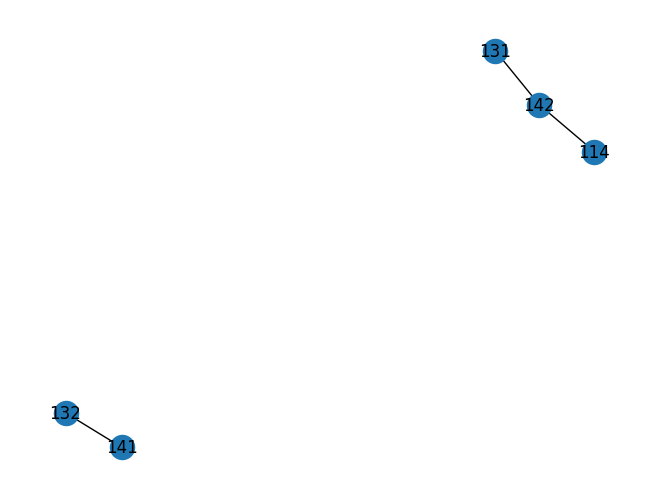

Performing node features query
Done with edge_df: 0.001125335693359375
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  114  142     14.12   31.335422               0.370529   
1  131  142     14.97   14.582371               0.215027   
2  141  132      6.99   82.430546               0.464387   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0                   0.0                0                       None   
1                   0.0                0                       None   
2                   0.0                0                      False   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  
1                          None                   None  
2                          None                   None  
Afer Node query: 
     u    v  sk_angle  width_diff 

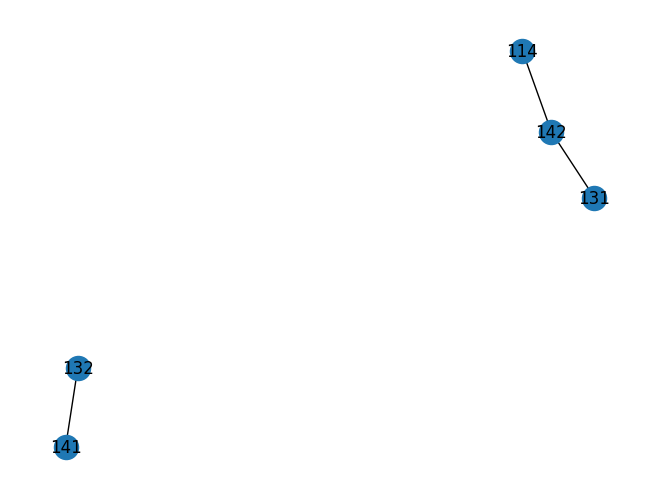

for upstream node 132, winning_node = 141, error_branches = [114 131 142]
Inside high_degree_false_positive_low_sibling_filter ****
Not exactly 2 downstream errors so returning
Current node skip distance was 1844.3747246878115 but max skip distance was 1906.2663347269172
Current node skip distance was 1482.9948556595195 but max skip distance was 1482.9948556595195
Current node skip distance was 1489.8229576486724 but max skip distance was 1489.8229576486724
Current node skip distance was 1984.170232995637 but max skip distance was 1984.170232995637
Current node skip distance was 1438.6446821350578 but max skip distance was 1438.6446821350578
Current node skip distance was 2300 but max skip distance was 2300.0
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0011718273162841797
Performing Edge Query
After edge filter, # of rows = 7
Exporting the edges
Delete

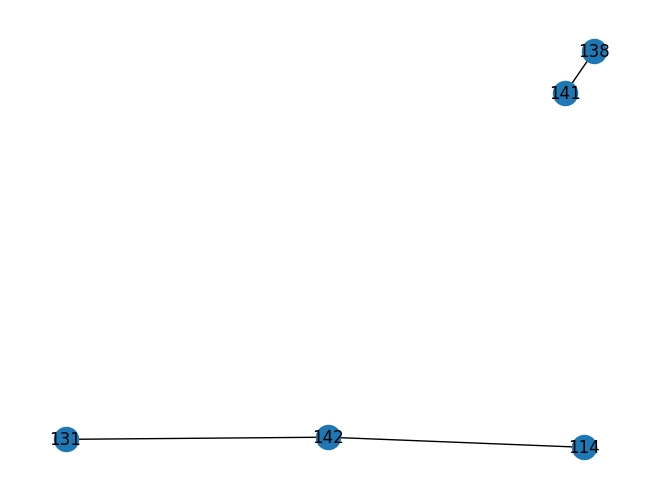

Performing global features query
Done with edge_df: 0.0011734962463378906
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  114  142     14.12   31.335422               0.370529   
1  131  142     14.97   14.582371               0.215027   
2  141  138      8.36  123.910521               0.565843   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0                   0.0                0                       None   
1                   0.0                0                       None   
2                   0.0                0                      False   

  definite_partner_width_delete  
0                          None  
1                          None  
2                          None  
Afer Global query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  114  142     14.12   31.335422               0.370529   

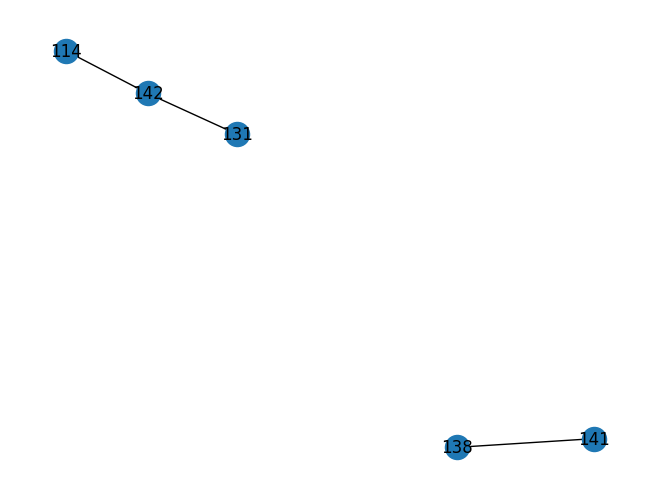

Performing node features query
Done with edge_df: 0.0015056133270263672
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  114  142     14.12   31.335422               0.370529   
1  131  142     14.97   14.582371               0.215027   
2  141  138      8.36  123.910521               0.565843   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0                   0.0                0                       None   
1                   0.0                0                       None   
2                   0.0                0                      False   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  
1                          None                   None  
2                          None                   None  
Afer Node query: 
     u    v  sk_angle  width_diff

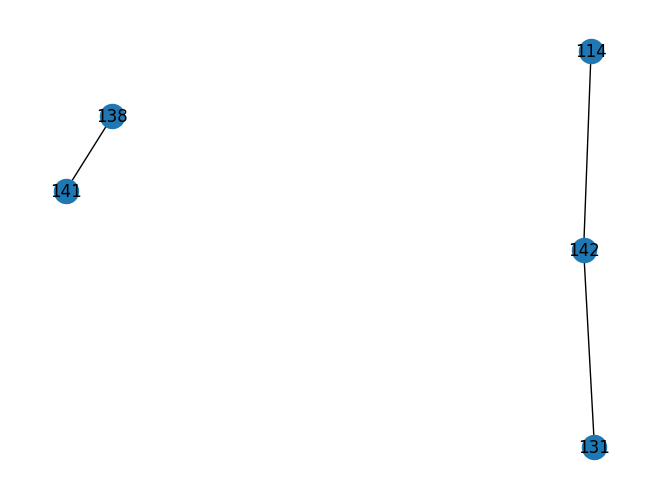

for upstream node 138, winning_node = 141, error_branches = [114 131 142]
Inside high_degree_false_positive_low_sibling_filter ****
Not exactly 2 downstream errors so returning
Current node skip distance was 1562.8057260398737 but max skip distance was 1562.8057260398737
Current node skip distance was 1388.4752639608032 but max skip distance was 1388.4752639608032
Current node skip distance was 1790.8779915181344 but max skip distance was 1844.3747246878115
Current node skip distance was 1532.930768923265 but max skip distance was 1532.930768923265
Current node skip distance was 1829.4403823438415 but max skip distance was 1829.4403823438415
Current node skip distance was 1421.724095731764 but max skip distance was 1587.281058495119
Current node skip distance was 1558.868122651933 but max skip distance was 1558.868122651933
Current node skip distance was 1515.3603088272669 but max skip distance was 1515.3603088272669
Current node skip distance was 1476.1917328180928 but max skip distan

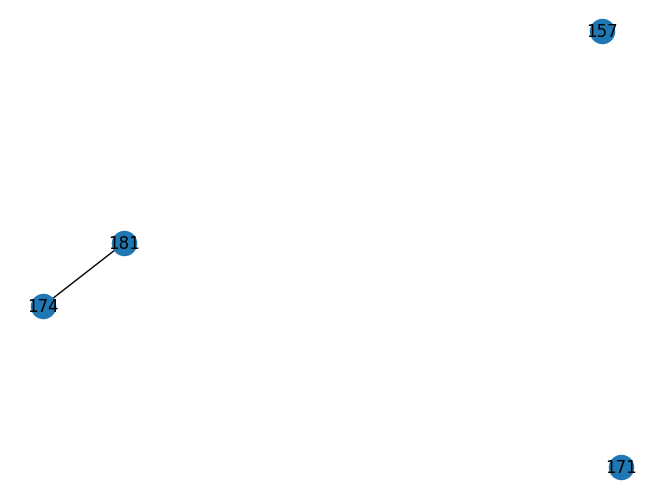

Performing global features query
Done with edge_df: 0.0012760162353515625
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  174  181      6.21    4.213437               0.020277   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0                   0.0                0                       False   

   definite_partner_width_delete  
0                          False  
Afer Global query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  174  181      6.21    4.213437               0.020277   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0                   0.0                0                       False   

   definite_partner_width_delete  
0                          False  


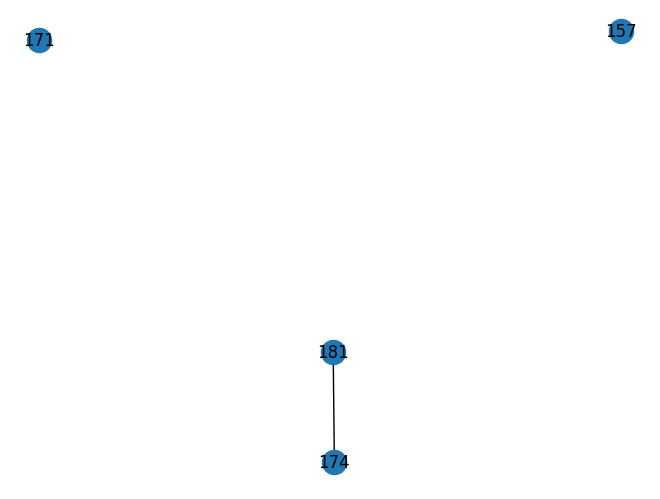

Performing node features query
Done with edge_df: 0.0011165142059326172
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  174  181      6.21    4.213437               0.020277   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0                   0.0                0                       False   

   definite_partner_width_delete above_threshold_delete  
0                          False                   None  
Afer Node query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  174  181      6.21    4.213437               0.020277   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0                   0.0                0                       False   

   definite_partner_width_delete above_threshold_delete  
0                          False                   None  


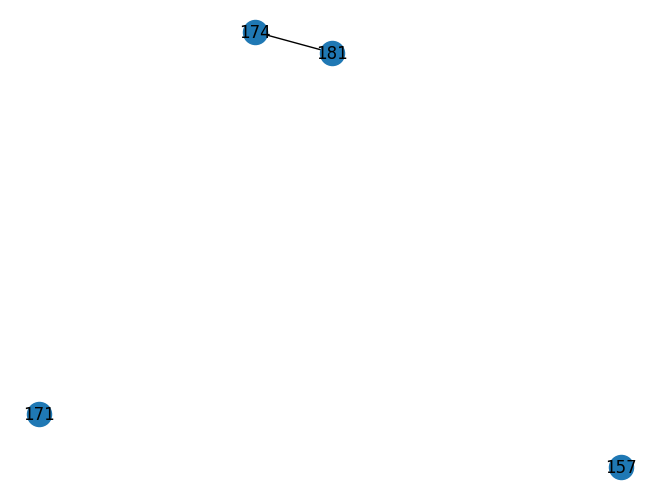

Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1839.1475043627702 but max skip distance was 1839.1475043627702
Current node skip distance was 1496.4470846611307 but max skip distance was 1839.1475043627702
Current node skip distance was 1545.639811575495 but max skip distance was 1545.639811575495
Current node skip distance was 1547.5571932935732 but max skip distance was 1723.7208049047854
Current node skip distance was 1799.7086984711018 but max skip distance was 1799.7086984711018
Current node skip distance was 1528.327643905881 but max skip distance was 1528.327643905881
Current node skip distance was 1443.4813042766386 but max skip distance was 1799.7086984711018
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.001094818115234375
Performing Edge Query
After edge filter, # of rows 

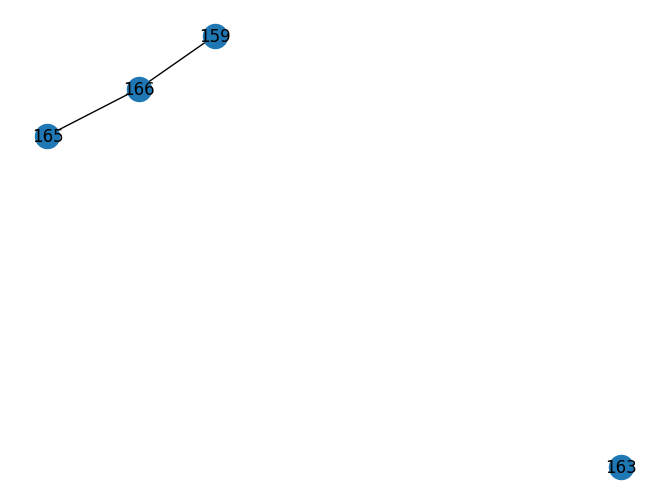

Performing global features query
Done with edge_df: 0.0010776519775390625
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  159  166     37.49    9.684155               0.122356   
1  166  165     62.35    3.027633               0.045573   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000029                1                       None   
1              0.000117                0                       None   

  definite_partner_width_delete  
0                          None  
1                          None  
Afer Global query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  159  166     37.49    9.684155               0.122356   
1  166  165     62.35    3.027633               0.045573   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000029         

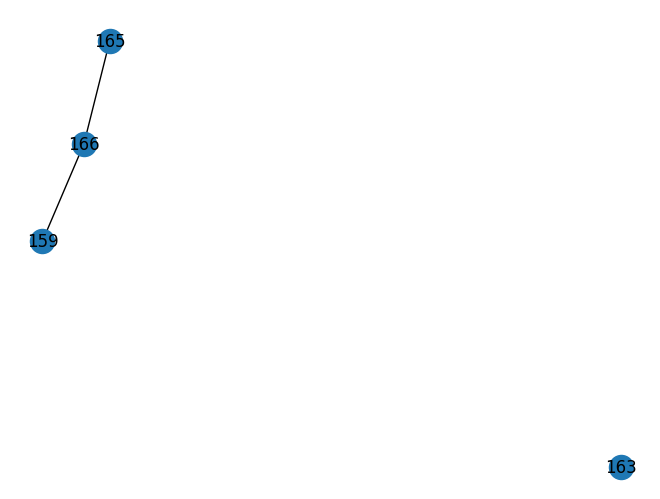

Performing node features query
Done with edge_df: 0.0012233257293701172
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  159  166     37.49    9.684155               0.122356   
1  166  165     62.35    3.027633               0.045573   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000029                1                       None   
1              0.000117                0                       None   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  
1                          None                   True  
Afer Node query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  159  166     37.49    9.684155               0.122356   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000029      

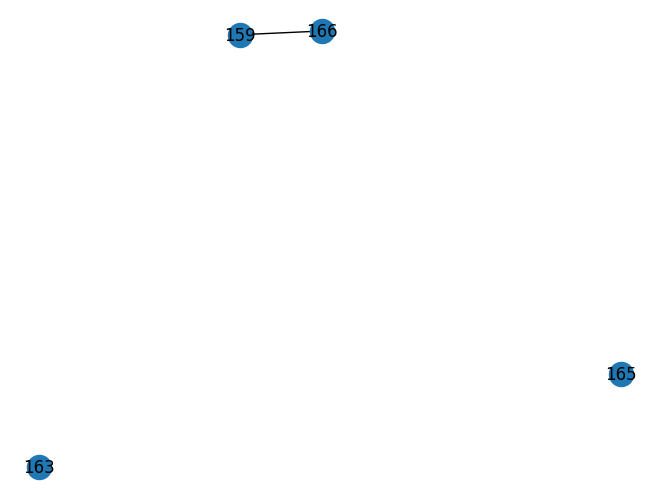

Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1456.096439990625 but max skip distance was 1456.096439990625
Current node skip distance was 1438.7677292204708 but max skip distance was 1438.7677292204708
Current node skip distance was 1473.679309601623 but max skip distance was 1823.5915015780708
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.001069784164428711
Performing Edge Query
After edge filter, # of rows = 5
Exporting the edges
Deleteing edges only

--- Before Local Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  160  165    150.60   24.518042               0.269567   
1  160  175      5.52   66.708406               0.733434   
2  160  168    145.72   17.270520               0.234389   
3  165  175     32.25   91.226447               1.373158   
4  165

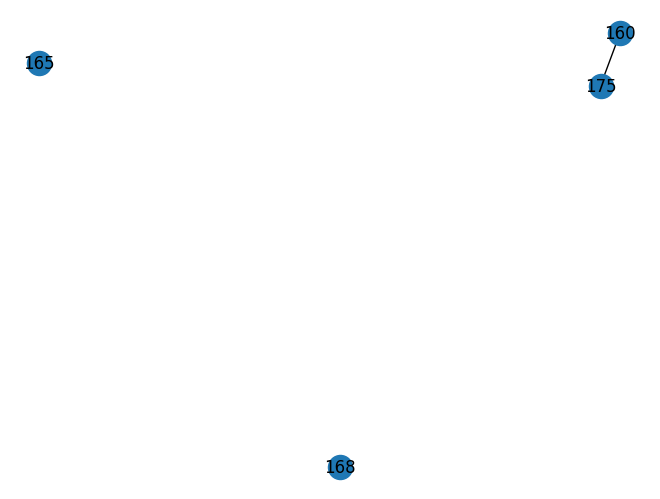

Performing global features query
Done with edge_df: 0.003055572509765625
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  160  175      5.52   66.708406               0.733434   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000058                1                       False   

  definite_partner_width_delete  
0                          None  
Afer Global query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  160  175      5.52   66.708406               0.733434   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000058                1                       False   

  definite_partner_width_delete  
0                          None  


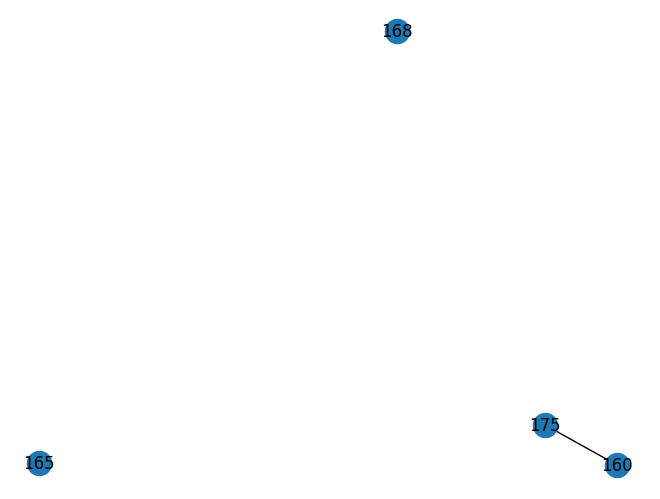

Performing node features query
Done with edge_df: 0.002367734909057617
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  160  175      5.52   66.708406               0.733434   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000058                1                       False   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  
Afer Node query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  160  175      5.52   66.708406               0.733434   

   synapse_density_diff  n_synapses_diff  definite_partner_sk_delete  \
0              0.000058                1                       False   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  


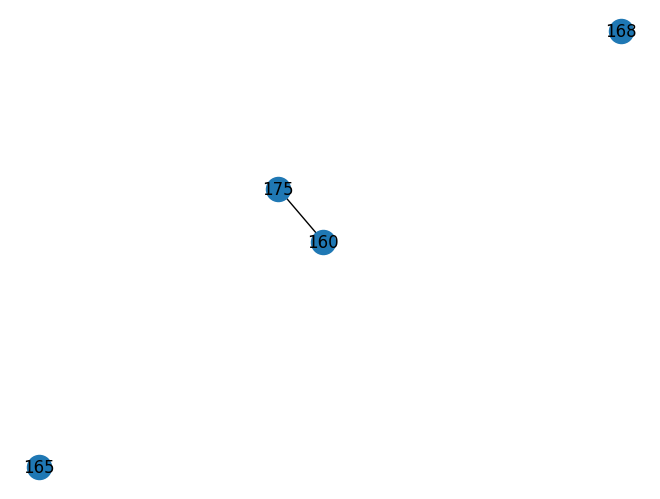

Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1499.8793134527978 but max skip distance was 1499.8793134527978
Current node skip distance was 1620.256694044604 but max skip distance was 1620.256694044604
Current node skip distance was 1397.2777743163138 but max skip distance was 1545.639811575495
Current node skip distance was 2032.4863095341002 but max skip distance was 2300.0
Current node skip distance was 1823.5915015780708 but max skip distance was 1823.5915015780708
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0016565322875976562
Performing Edge Query
After edge filter, # of rows = 6
Exporting the edges
Deleteing edges only

--- Before Local Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  176  180      6.40    5.328512               0.092817   
1  176 

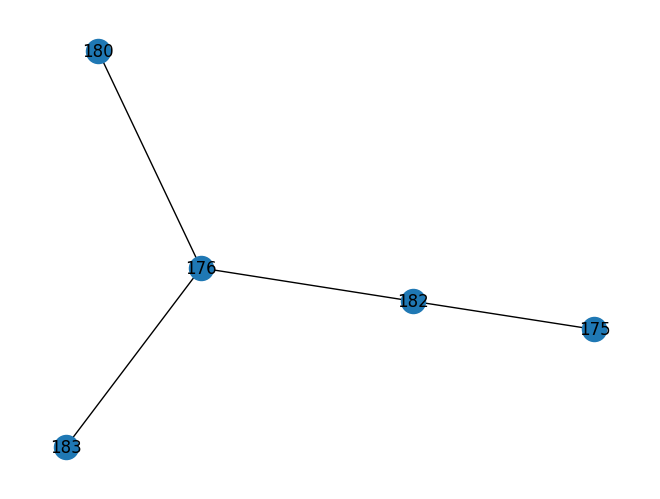

Performing global features query
Done with edge_df: 0.00110626220703125
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  176  180      6.40    5.328512               0.092817   
1  176  182     54.70   44.139437               0.768864   
2  176  183      8.95    4.869116               0.084815   
3  182  175     64.98   56.113901               0.355913   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000000                0                       None   
1              0.000243                1                       None   
2              0.000000                0                       None   
3              0.000243                1                       None   

  definite_partner_width_delete  
0                          None  
1                          None  
2                          None  
3         

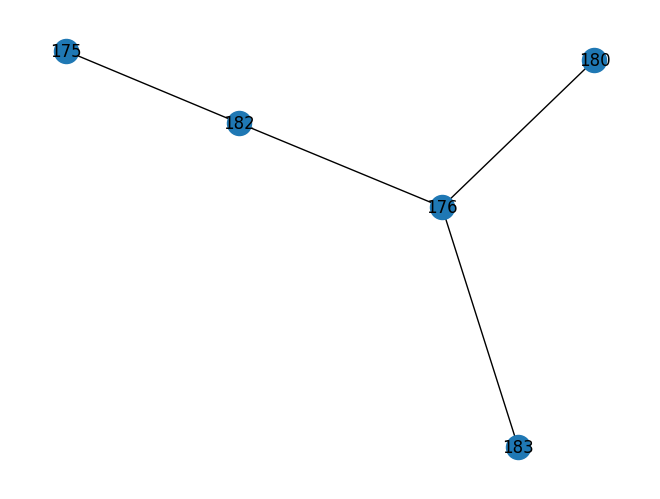

Performing node features query
Done with edge_df: 0.0012364387512207031
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  176  180      6.40    5.328512               0.092817   
1  176  182     54.70   44.139437               0.768864   
2  176  183      8.95    4.869116               0.084815   
3  182  175     64.98   56.113901               0.355913   

   synapse_density_diff  n_synapses_diff definite_partner_sk_delete  \
0              0.000000                0                       None   
1              0.000243                1                       None   
2              0.000000                0                       None   
3              0.000243                1                       None   

  definite_partner_width_delete above_threshold_delete  
0                          None                   None  
1                          None   

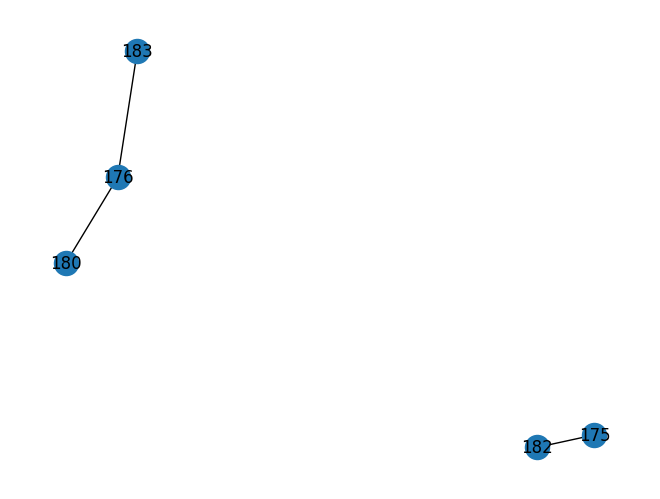

for upstream node 175, winning_node = 182, error_branches = [176 180 183]
Inside high_degree_false_positive_low_sibling_filter ****
Not exactly 2 downstream errors so returning
Current node skip distance was 1405.8692599063027 but max skip distance was 1405.8692599063027
Current node skip distance was 2300 but max skip distance was 2300.0
Current node skip distance was 1663.4255326721589 but max skip distance was 1663.4255326721589
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.002813577651977539
Performing Edge Query
After edge filter, # of rows = 2
Exporting the edges
Deleteing edges only

--- Before Local Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  176  182     54.70   44.139437               0.768864   
1  176  183      8.95    4.869116               0.084815   
2  176  179    165.29   61.813505               0.518473   
3

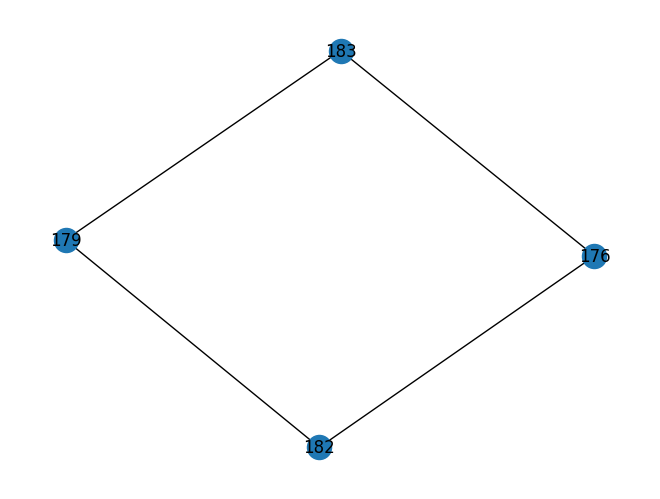

Performing global features query
Done with edge_df: 0.0025925636291503906
Performing Edge Query
After edge filter, # of rows = 2
Exporting the edges
Deleteing edges only

--- Before Global Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  176  182     54.70   44.139437               0.768864   
1  176  183      8.95    4.869116               0.084815   
2  182  179     57.59   17.674069               0.148245   
3  183  179     22.87   66.682621               0.559314   

   synapse_density_diff  n_synapses_diff  definite_partner_width_delete  \
0              0.000243                1                           True   
1              0.000000                0                          False   
2              0.000243                1                          False   
3              0.000000                0                           True   

  definite_partner_sk_delete  
0                       None  
1                       None  
2                       None  


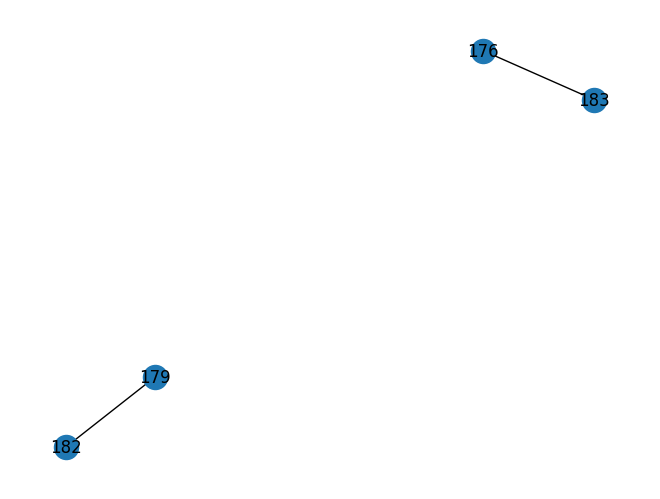

Performing node features query
Done with edge_df: 0.0013346672058105469
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  176  183      8.95    4.869116               0.084815   
1  182  179     57.59   17.674069               0.148245   

   synapse_density_diff  n_synapses_diff  definite_partner_width_delete  \
0              0.000000                0                          False   
1              0.000243                1                          False   

  definite_partner_sk_delete above_threshold_delete  
0                       None                   None  
1                       None                   None  
Afer Node query: 
     u    v  sk_angle  width_diff  width_diff_percentage  \
0  176  183      8.95    4.869116               0.084815   
1  182  179     57.59   17.674069               0.148245   

   synapse_density_diff  n_synapses_d

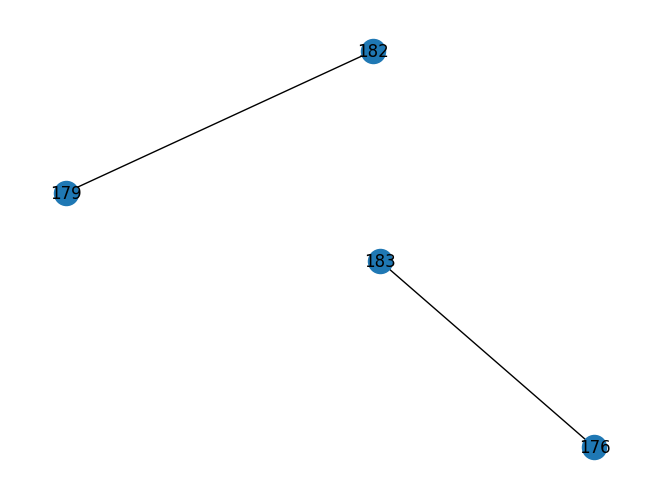

for upstream node 179, winning_node = 182, error_branches = [176 183]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (101.54805929174576) less than width_min(250)
Current node skip distance was 1428.0713915564047 but max skip distance was 1428.0713915564047
Current node skip distance was 2097.673414519897 but max skip distance was 2290.7056824915994
Current node skip distance was 1589.7835803822734 but max skip distance was 1589.7835803822734
Current node skip distance was 1385.5812786224683 but max skip distance was 1385.5812786224683
Current node skip distance was 2199.973957500283 but max skip distance was 2199.973957500283
Current node skip distance was 1907.1869472675644 but max skip distance was 1907.1869472675644
limb_branch_dict_to_cancel = {'L3': array([105, 115, 102, 104, 145, 178, 147, 177, 150, 153, 156, 157, 152,
       173, 168, 167, 179, 182, 184, 185, 187, 189, 186, 188,  96,  65,
        64,  67,  71,  74,  77,  85,  88, 154, 155, 158, 161, 16

In [96]:
neuron_obj_proof = npu.auto_proof_stage(
    neuron_obj_axon,
    mesh_decimated = mesh_decimated,
    calculate_after_proof_stats = False,
)

In [97]:
_ = npu.after_auto_proof_stats(
    neuron_obj_proof,
    store_in_obj = True,
)


Working on compartment basal---
Compartment limb stats = {'n_limbs': 4, 'soma_angle_max': 125.96, 'soma_angle_min': 90.34}

Working on compartment apical_total---
Compartment limb stats = {'n_limbs': 1, 'soma_angle_max': 32.26, 'soma_angle_min': 32.26}

Working on compartment axon---
Compartment limb stats = {'n_limbs': 1, 'soma_angle_max': 156.14, 'soma_angle_min': 156.14}

Working on compartment dendrite---
Compartment limb stats = {'n_limbs': 5, 'soma_angle_max': 125.96, 'soma_angle_min': 32.26}


# Saving off the autoproofread neuron

In [98]:
vdi.save_neuron_obj_auto_proof(
    neuron_obj_proof,
)

Total time for soma meshes compression = 0.45603036880493164
Total time for insignificant_limbs,inside_pieces,non_soma_touching_meshes,not_processed_soma_containing_meshes compression = 0.3922741413116455
Total time for limb_meshes compression = 1.80808687210083
    Starting Limb Correspondence Compression
Total time for new_limb_correspondence compression = 10.859582424163818
Cleared mesh: <trimesh.Trimesh(vertices.shape=(15723, 3), faces.shape=(38825, 3))>:139746512328256
Cleared mesh: <trimesh.Trimesh(vertices.shape=(4348, 3), faces.shape=(8941, 3))>:139746220906192
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1586, 3), faces.shape=(3510, 3))>:139746512327488
Cleared mesh: <trimesh.Trimesh(vertices.shape=(808, 3), faces.shape=(1812, 3))>:139746512327920
Cleared mesh: <trimesh.Trimesh(vertices.shape=(806, 3), faces.shape=(1809, 3))>:139746502520064
Cleared mesh: <trimesh.Trimesh(vertices.shape=(805, 3), faces.shape=(1808, 3))>:139746614605664
Cleared mesh: <trimesh.Trimesh(vertices

'864691134917511946_auto_proof.pbz2'

# Plotting the final neuron

In [99]:
from neurd import synapse_utils as syu

In [100]:
from datasci_tools import ipyvolume_utils as ipvu
ipvu.plot_objects(
    neuron_obj_axon.mesh,
    meshes = [neuron_obj_proof.mesh],
    meshes_colors="red"
)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [101]:
syu.plot_synapses(neuron_obj_proof)


 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [102]:
syu.plot_synapses_error_from_neuron_obj(neuron_obj_proof)    

# of error synapses = 199

 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [103]:
syu.plot_synapses_valid_from_neuron_obj(neuron_obj_proof)  

# of valid synapses = 2116

 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [104]:
nviz.plot_compartments(neuron_obj_proof)


 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

apical:blue
apical_shaft:aqua
apical_tuft:purple
basal:yellow
axon:red
oblique:green


Unlabeled: transparent green


In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
